# EEG and Unity Timestamps Alignment and Trigger Files for ERP Analysis
This notebook is intended to create the descriptive, streams information and timestamps as '.csv' files, and trigger files.
- Descriptive files contain information about the recordings such as duration, sampling rate, names of streams collected, type, etc.
- Stream information files contain all data gathered during recording with respective timestamps (e.g., head and eye tracking, object names)
- The trigger files contain information about the time when an image was shown, the type of image, distance, rotation and block. These files are required to set the stimulus onset during the eeg data analysis.

In [1]:
import copy
import datetime
import itertools
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
from matplotlib import patches
import matplotlib.gridspec as gridspec
import numpy as np
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import pyxdf
import dataframe_image as dfi
import seaborn as sns
from scipy.signal import find_peaks
from operator import itemgetter
from tqdm.notebook import tqdm


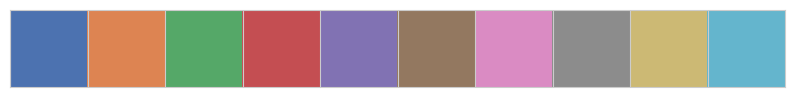

In [2]:
# choosing the color palette
deep_pal = sns.color_palette('deep')
sns.palplot(deep_pal)
colors = dict(startMessage=deep_pal[6], fixCross=deep_pal[5], image=sns.color_palette("hls", 10)[9], grayCanvas=deep_pal[4], endMessage=deep_pal[7])
# colors_cat = dict(object=deep_pal[0], face=deep_pal[1], body=deep_pal[3])
sns.set_style("white")

In [3]:
sns.color_palette("hls", 12)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.6312, 0.33999999999999997),
 (0.8287999999999999, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.86, 0.6312),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.5688000000000001, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8287999999999999),
 (0.86, 0.33999999999999997, 0.5688000000000001)]

## 1. Importing XDF Files

In [4]:
# path to data stored
r_path = "data"
# path to store trigger data
t_path = r_path + '/triggers'
# path to store eye-tracking data
e_path = r_path + '/eye_tracking'
# path to store subjects' full streams data
all_csv_path = r_path + '/streams_csv'

# Get some quick idea about the files
files = os.listdir(r_path)  # get all files from the folder "data"
files.sort()  # sort them alphabetically
recordings = {}
file_names = []
for i, file in enumerate(files):  # store and display all files
    if file.endswith('.xdf') and 'room1' in file:
        file_names.append(file)
        created = os.path.getmtime(f"data/{file}")  # creation timestamp
        created = datetime.datetime.fromtimestamp(created)  # translate as datetime
        created = created.strftime("%d.%m.%Y %H:%M")  # arrange it
        recordings[i] = {"file": file, "created": created}
        #check for a second recording for same subject
        if os.path.isfile(f"data/{file.replace('room1', 'room2')}"):
            print(f"2nd room exists for {file}")

# print(file_names)
files = [f.split(".")[0] for f in files]
print("Included:")
display(recordings)

2nd room exists for 45_room1_161122.xdf
Included:


{1: {'file': '39_room1_251022.xdf', 'created': '25.10.2022 16:40'},
 2: {'file': '40_room1_261022.xdf', 'created': '26.10.2022 16:54'},
 3: {'file': '41_room1_021122.xdf', 'created': '02.11.2022 15:20'},
 4: {'file': '42_room1_081122.xdf', 'created': '08.11.2022 15:14'},
 5: {'file': '43_room1_031122.xdf', 'created': '03.11.2022 11:51'},
 6: {'file': '44_room1_111122.xdf', 'created': '11.11.2022 11:38'},
 7: {'file': '45_room1_161122.xdf', 'created': '16.11.2022 14:15'},
 9: {'file': '46_room1_291122.xdf', 'created': '29.11.2022 15:17'},
 10: {'file': '47_room1_071222.xdf', 'created': '07.12.2022 12:07'},
 11: {'file': '48_room1_081222.xdf', 'created': '08.12.2022 11:12'},
 12: {'file': '49_room1_161222.xdf', 'created': '12.01.2023 21:00'},
 13: {'file': '50_room1_250123.xdf', 'created': '30.01.2023 13:44'},
 14: {'file': '51_room1_270123.xdf', 'created': '30.01.2023 13:56'},
 15: {'file': '53_room1_140223.xdf', 'created': '14.02.2023 13:32'},
 16: {'file': '55_room1_130223.xdf', 'crea

### 1.1 Load data

In [5]:
# check streams for recording 0
file_to_use = file_names[2]
print(file_to_use)
streams, _ = pyxdf.load_xdf(f"data/{file_to_use}")

41_room1_021122.xdf


In [6]:
# stream channel names in recording 0
s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
s_channels
# Get an idea of stream 'ImageInfo'
# streams[7]
# streams[7]['info']
# streams[7]['time_series']
# streams[7]['time_stamps']
# length of time_stamps
# len(streams[2]['time_stamps'])
# print all source_ids in stream 7
# source_ids = [i['info']['source_id'] for i in streams]
# source_ids

{'openvibeSignal': 0,
 'EyeTrackingLocal': 1,
 'Visual': 2,
 'HitObjectNames': 3,
 'ImagesOrder': 4,
 'HitObjectPositions': 5,
 'HeadTracking': 6,
 'EyeTrackingWorld': 7,
 'ValidationError': 8,
 'ImageInfo': 9,
 'HitPositionOnObjects': 10}

### 1.2 Important Functions

In [7]:
def stract_eeg_data(streams, time_ref_stream='openvibeSignal'):
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
    eeg = s_channels[time_ref_stream]
    # choose 6144 samples which correspond to 6 sec of recording
    df_eeg = pd.DataFrame(streams[eeg]['time_series'][0:6144,0:10]).rename(columns={0: "Ch1", 1: "Ch2", 2: "Ch3",3: "Ch4", 4: "Ch5",5: "Ch6", 6: "Ch7", 7: "Ch8",8: "Ch9", 9: "Ch10"})
    df_eeg['timestamps'] = streams[eeg]['time_stamps'][0:6144] - streams[eeg]['time_stamps'][0]
    # have all timestamps
    df_eeg_all = pd.DataFrame(streams[eeg]['time_series'][:,0:10]).rename(columns={0: "Ch1", 1: "Ch2", 2: "Ch3",3: "Ch4", 4: "Ch5",5: "Ch6", 6: "Ch7", 7: "Ch8",8: "Ch9", 9: "Ch10"})
    df_eeg_all['timestamps'] = streams[eeg]['time_stamps']
    return df_eeg, df_eeg_all

In [8]:
df_eeg, df_eeg_all = stract_eeg_data(streams)
df_eeg_all


,Ch1,Ch2,Ch3,Ch4,Ch5,Ch6,Ch7,Ch8,Ch9,Ch10,timestamps
0,-2439.598877,-6373.367188,-4181.371094,-2586.020264,-677.174988,-1513.680908,-4054.148926,339.626526,-157.859756,-3396.265137,532357.754064
1,-2437.576172,-6366.139648,-4187.145508,-2584.567383,-677.156555,-1516.163574,-4056.447754,337.566833,-158.080444,-3397.993896,532357.755041
2,-2442.780518,-6362.848145,-4188.561523,-2585.909912,-678.995605,-1518.591064,-4065.495605,337.493286,-159.845886,-3400.494873,532357.756018
3,-2446.127441,-6360.696289,-4193.692383,-2583.942139,-675.262390,-1520.889771,-4069.375977,336.187592,-161.850388,-3400.715576,532357.756994
4,-2445.208008,-6356.227539,-4193.545410,-2589.017822,-670.536194,-1519.069214,-4062.663574,331.479736,-161.666489,-3400.108643,532357.757971
...,...,...,...,...,...,...,...,...,...,...,...
3977147,-4319.020020,-7427.003906,-3608.301758,-3827.823242,-3982.777344,-2644.445312,-6729.066406,-928.970825,-1421.105591,-9947.022461,536241.686683
3977148,-4320.564941,-7400.025391,-3586.767090,-3837.992920,-3991.972412,-2653.014893,-6716.083008,-918.911499,-1374.836426,-9953.661133,536241.687659
3977149,-4307.305664,-7381.157227,-3567.237061,-3852.741699,-4000.395020,-2658.587158,-6717.425781,-912.364685,-1337.412720,-9960.722656,536241.688636
3977150,-4294.690430,-7356.919434,-3548.295410,-3874.221191,-4010.767090,-2654.522949,-6720.919922,-907.068359,-1380.923462,-9963.040039,536241.689613


In [9]:
# visualize eeg data only
def visualize_eeg(df):
    fig, ax = plt.subplots(nrows=10, figsize=(15, 6), sharex=True)
    plt.rcParams.update({'font.size': 10})
    for i, value in enumerate(df.columns[0:10]):
        sns.lineplot(x= df['timestamps'] - df['timestamps'][0], y = df[value], ax=ax[i], linewidth=0.5)
        ax[i].set(yticklabels=[])
        ax[i].set_xlim(0,None)
        ax[i].set_xlabel('Time (s)', fontsize=12)
        sns.despine(top=True, bottom=True)
    plt.show()
# plt.savefig("data/images/" + "eeg_6seconds" + ".pdf", format='pdf', dpi=1200)


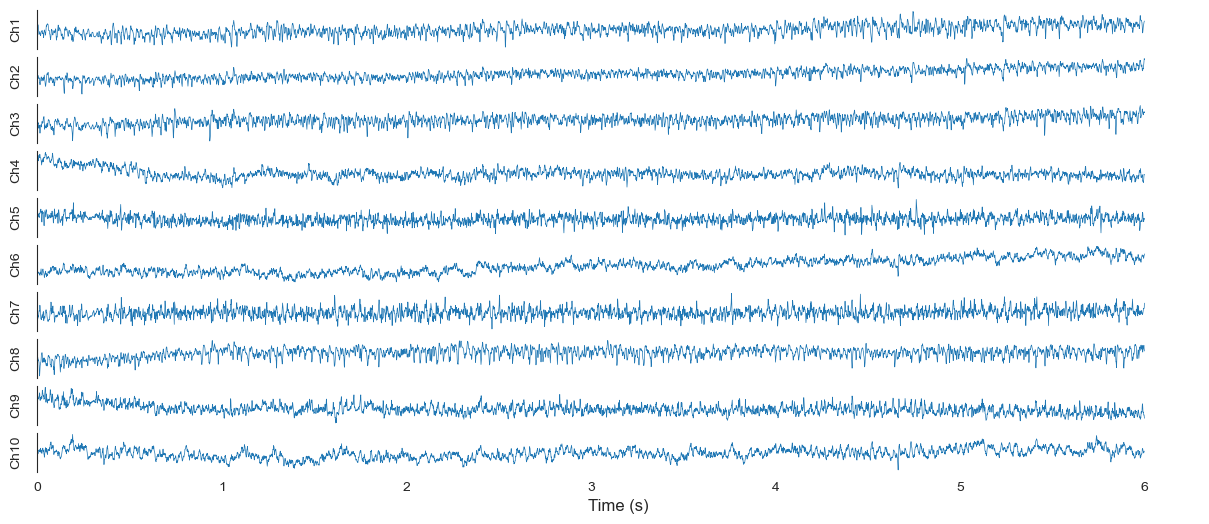

In [10]:
visualize_eeg(df_eeg)

In [11]:
def get_stream_timestamps(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal', use_manual_drift = False, useAllStreams = False):
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
    times_egg_start_ts = streams[s_channels[time_ref_stream]]['time_stamps'][0]
    times_egg_end_ts = streams[s_channels[time_ref_stream]]['time_stamps'][-1]

    # Save user ID from Visual stream
    uid = streams[s_channels['Visual']]['info']['uid'][0]
    print(f"\nParticipant UID: {uid}")

    times_unity_min = []
    times_unity_max = []
    streams_used = []

    if useAllStreams:
        streams_keep = [streams[i]["info"]["name"][0] for i in range(len(streams))]

    for i in range(len(streams)):
        stream_name = streams[i]["info"]["name"][0]
        if stream_name in streams_keep and stream_name != time_ref_stream:
            if len(streams[i]['time_stamps']) > 0:
                times_unity_min.append(streams[i]['time_stamps'][0])
                times_unity_max.append(streams[i]['time_stamps'][-1])
                streams_used.append(stream_name)
    # select earliest timestamp
    times_unity_start_ts = np.min(times_unity_min)
    # select latest timestamp
    times_unity_end_ts = np.max(times_unity_max)

    # The following code calculates 3 different issue
    # issue A: delayed start of unity streams vs. eeg streams
    # issue B: initial drift between time stamps of unity and egg streams
    # issue C: linearly increasing drift between time stamps of unity and egg streams over time

    # Read drifts from recording notes
    if use_manual_drift and os.path.isfile(path = r_path + '/custom_drifts.csv'):
        cdrifts = pd.read_csv(r_path + '/custom_drifts.csv')
    else:
        cdrifts = pd.DataFrame(columns=['uid'])

    # 0/ Custom drifts are defined for given participant taken from participant notes
    if len(cdrifts[cdrifts['uid'] == uid]) == 1:
        print(f"!! Custom drifts from participant notes found")
        start_diff = cdrifts[cdrifts['uid'] == uid]['start_drift'].iloc[0]
        end_diff = cdrifts[cdrifts['uid'] == uid]['end_drift'].iloc[0]

    # 1/ normal case without issue A present
    else:
        start_diff = times_unity_start_ts - times_egg_start_ts # start difference between unity and eeg # issue B
        end_diff = times_unity_end_ts - times_egg_end_ts # end difference between unity and eeg

    dynamic_shift = end_diff - start_diff # drift increase over time # issue C
    delayed_start_shift = 0

    # 2/ In case drift is larger at the start vs. at the end, we deal with a case of delayed recording start, i.e. issue A is present
    # we need to calculate the dalay in recording and correct for it to know the dynamic shift
    ##
    if start_diff > end_diff:
        # assume normalized drift in ms per one minute of duration of -1.25256887748983
        normalized_drift_over_time = -1.25256887748983
        duration = (times_egg_start_ts - times_egg_end_ts) / 60
        dynamic_shift = min(end_diff, duration * normalized_drift_over_time / 1000) # issue C, calculated based on assumed normalized drift in ms per minute of duration
        start_diff = end_diff - dynamic_shift # issue B, calculated based that issue C is now known
        delayed_start_shift = (times_unity_start_ts - times_egg_start_ts) - start_diff # issue A, backed out using corrected B, it is going to be zero for case 0/
    ##
    print(f"Streams to keep: {streams_used} and reference stream ['{time_ref_stream}']")
    print(f"{time_ref_stream} start time is {times_egg_start_ts} and end time is {times_egg_end_ts}")
    print(f"Unity start time is {times_unity_start_ts} and end time is {times_unity_end_ts}")
    if delayed_start_shift != 0: # report that issue A is present
        print(f" !! Unity delayed recording start by {delayed_start_shift} seconds detected")
    i = 0
    for _, ch_name in enumerate(streams_used):
        print(f" -- Unity {ch_name} start time is {times_unity_min[i]} and end time is {times_unity_max[i]}")
        i += 1
    print(f" -- All Unity streams start time difference is {round(1000 * (np.max(times_unity_min) - np.min(times_unity_min)), 1)} (milliseconds)")
    print(f" -- All Unity streams end time difference is {round(1000 * (np.max(times_unity_max) - np.min(times_unity_max)), 1)} (milliseconds)")
    print(f"Starting drift between Unity and {time_ref_stream} is {1000*start_diff} (milliseconds)")
    if delayed_start_shift != 0: # report that correct value for issue B had to be calculated using assumption
        print(f" !! Making corrections using a normalized drift in ms per one minute of duration at -1.25256887748983")
    print(f"Ending drift between Unity and {time_ref_stream} is {1000*end_diff} (milliseconds)")
    print(f"Additional drift over time is {round(1000*dynamic_shift,2)} (milliseconds)")

    return times_egg_start_ts, times_egg_end_ts, times_unity_start_ts, times_unity_end_ts, start_diff, end_diff, dynamic_shift, delayed_start_shift

In [12]:
get_stream_timestamps(streams, streams_keep=['ImageInfo','Visual'], useAllStreams=False)


Participant UID: f8780dc1-6310-4759-9d7b-a59548ab6397
Streams to keep: ['Visual', 'ImageInfo'] and reference stream ['openvibeSignal']
openvibeSignal start time is 532357.7540644857 and end time is 536241.6905890936
Unity start time is 532358.001049673 and end time is 536239.3086369165
 !! Unity delayed recording start by 0.2469851872883737 seconds detected
 -- Unity Visual start time is 532358.001049673 and end time is 536239.3086351864
 -- Unity ImageInfo start time is 532358.0010562824 and end time is 536239.3086369165
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 0.0 (milliseconds)
 !! Making corrections using a normalized drift in ms per one minute of duration at -1.25256887748983
Ending drift between Unity and openvibeSignal is -2381.9521771511063 (milliseconds)
Additional drift over time is -2381.95 (milliseconds)


(532357.7540644857,
 536241.6905890936,
 532358.001049673,
 536239.3086369165,
 0.0,
 -2.3819521771511063,
 -2.3819521771511063,
 0.2469851872883737)

In [13]:
(90275.76089333574 - 90275.54623195817) * 1000

214.6613775694277

In [14]:
def get_continuous_time_periods(time_stamps_input):
    # duration = (time_stamps_input[-1] - time_stamps_input[0])/60
    # print(f'Recording duration: {duration} minutes')
    time_stamps_shift = time_stamps_input[1:-1] - time_stamps_input[0:-2]
    time_stamps_shift_pd = pd.array(time_stamps_shift)
    cutoff = np.mean(time_stamps_shift) + 2*np.std(time_stamps_shift)
    #cutoff = 30
    last = 0
    chunks = []
    for i, val in enumerate(time_stamps_shift):
        if val > cutoff:
            chunks.append([time_stamps_input[last:i+1]])
            last = i+1
    chunks.append([time_stamps_input[last:(np.size(time_stamps_input))]])
    return chunks

def calcualte_fps(time_stamp_chunk):
    frame_count = np.size(time_stamp_chunk)
    chunck_duration = (np.max(time_stamp_chunk) - np.min(time_stamp_chunk) )/ 60
    # if chunck_duration > 1:
    fps = frame_count / (chunck_duration * 60)
    return fps

total_size = 0
time_stamps = streams[s_channels['Visual']]['time_stamps']
for chunk in get_continuous_time_periods(time_stamps):
    print(calcualte_fps(chunk))
    total_size += np.size(chunk)
    print(np.size(chunk))
    print(chunk)

print(f"Total input array size {np.shape(time_stamps)} vs. summed chunk sizes {total_size}")
print(f"first entry {time_stamps[0]} and last entry {time_stamps[-1]}")

90.0013550482881
75800
[array([532358.00104967, 532358.01199795, 532358.02293993, ...,
       533200.18843405, 533200.19955053, 533200.21059151])]
90.0088016017639
105302
[array([533236.80387918, 533236.80832767, 533236.80860777, ...,
       534406.68951454, 534406.70061502, 534406.71168959])]
90.01033553302376
83436
[array([534439.49718935, 534439.50226994, 534439.50247434, ...,
       535366.43504754, 535366.44621412, 535366.4574046 ])]
90.02330294693236
36879
[array([535401.28553195, 535401.29192554, 535401.29215464, ...,
       535810.92386887, 535810.93502955, 535810.94612863])]
90.02173143527907
35594
[array([535843.91521815, 535843.91557425, 535843.91573665, ...,
       536239.28662243, 536239.29751891, 536239.30863519])]
Total input array size (337011,) vs. summed chunk sizes 337011
first entry 532358.001049673 and last entry 536239.3086351864


In [15]:
def describe_recordings(streams, file_name=''):
    ch_keys = ["name","type", "channel_count","channel_format","nominal_srate","desc","effective_srate","hostname", "created_at"]
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
    # Save user ID from Visual stream
    uid = streams[s_channels['Visual']]['info']['uid'][0]
    # Get the streams timestamps
    times_egg_start_ts, times_egg_end_ts, times_unity_start_ts, times_unity_end_ts, start_diff, end_diff, dynamic_shift, delayed_start_shift = get_stream_timestamps(streams)
    # Calculate the total duration of the recording
    duration = (times_egg_end_ts - times_egg_start_ts) / 60
    # Calculate the mean FPS for the Unity stream (it should be 90 fps)
    fps = np.mean([calcualte_fps(chunk) for chunk in get_continuous_time_periods(streams[s_channels['Visual']]['time_stamps'])])
    # print(fps)

    df = pd.DataFrame(columns=np.concatenate([['uid','file_name','duration (min)','unity_avg_fps','unity_recording_delayed_start(s)',
                                               'eeg_unity_ts_delta_start(s)','eeg_unity_ts_delta_end(s)',
                                               'drift_over_time(s)','stream_id'], ch_keys]))
    id_o = []
    for id, stream in enumerate(streams):
        id_o.append(id)
        items = itemgetter(*ch_keys)(dict(stream['info']))
        items = [(', '.join(list(item[0].keys())) if 'desc' in ch_keys[i] else (
                  item[0] if isinstance(item, list) else item)) for i, item in enumerate(items)]
        df = df.append(pd.Series(items, index=ch_keys), ignore_index=True)

    df['uid'] = np.resize(uid,len(streams))
    df['file_name'] = np.resize(file_name,len(streams))
    df['duration (min)'] = np.resize(duration,len(streams))
    df['unity_avg_fps'] = np.resize(fps,len(streams))
    df['unity_recording_delayed_start(s)'] = np.resize(delayed_start_shift, len(streams)) # issue A
    df['eeg_unity_ts_delta_start(s)'] = np.resize(start_diff, len(streams)) # issue B
    df['eeg_unity_ts_delta_end(s)'] = np.resize(end_diff, len(streams))
    df['drift_over_time(s)'] = np.resize(dynamic_shift,len(streams)) # issue C
    df['stream_id'] = id_o

    return df

In [16]:
desc_streams = describe_recordings(streams, file_name=file_to_use)
# dfi.export(desc_streams,'data/description.png')
desc_streams


Participant UID: f8780dc1-6310-4759-9d7b-a59548ab6397
Streams to keep: ['Visual', 'ImageInfo'] and reference stream ['openvibeSignal']
openvibeSignal start time is 532357.7540644857 and end time is 536241.6905890936
Unity start time is 532358.001049673 and end time is 536239.3086369165
 !! Unity delayed recording start by 0.2469851872883737 seconds detected
 -- Unity Visual start time is 532358.001049673 and end time is 536239.3086351864
 -- Unity ImageInfo start time is 532358.0010562824 and end time is 536239.3086369165
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 0.0 (milliseconds)
 !! Making corrections using a normalized drift in ms per one minute of duration at -1.25256887748983
Ending drift between Unity and openvibeSignal is -2381.9521771511063 (milliseconds)
Additional drift over time is -2381.95 (milliseconds)


,uid,file_name,duration (min),unity_avg_fps,unity_recording_delayed_start(s),eeg_unity_ts_delta_start(s),eeg_unity_ts_delta_end(s),drift_over_time(s),stream_id,name,type,channel_count,channel_format,nominal_srate,desc,effective_srate,hostname,created_at
0,f8780dc1-6310-4759-9d7b-a59548ab6397,41_room1_021122.xdf,64.732275,90.013105,0.246985,0.0,-2.381952,-2.381952,0,openvibeSignal,signal,72,float32,1024.000000000000,channels,1024.0,wd-left,532025.3964535000
1,f8780dc1-6310-4759-9d7b-a59548ab6397,41_room1_021122.xdf,64.732275,90.013105,0.246985,0.0,-2.381952,-2.381952,1,EyeTrackingLocal,Markers,6,float32,0.000000000000000,"ETLoriginX, ETLoriginY, ETLoriginZ, ETLdirecti...",0.0,ml03,532140.4215004999
2,f8780dc1-6310-4759-9d7b-a59548ab6397,41_room1_021122.xdf,64.732275,90.013105,0.246985,0.0,-2.381952,-2.381952,2,Visual,Markers,3,float32,0.000000000000000,"cFrame, displayStatus, worldTime",0.0,ml03,532140.4277261000
3,f8780dc1-6310-4759-9d7b-a59548ab6397,41_room1_021122.xdf,64.732275,90.013105,0.246985,0.0,-2.381952,-2.381952,3,HitObjectNames,Markers,1,string,0.000000000000000,HON,0.0,ml03,532140.4240541999
4,f8780dc1-6310-4759-9d7b-a59548ab6397,41_room1_021122.xdf,64.732275,90.013105,0.246985,0.0,-2.381952,-2.381952,4,ImagesOrder,Markers,2,string,0.000000000000000,"arrayOfImages, orderOfImageIndexesToDisplay",0.0,ml03,532140.4305822999
5,f8780dc1-6310-4759-9d7b-a59548ab6397,41_room1_021122.xdf,64.732275,90.013105,0.246985,0.0,-2.381952,-2.381952,5,HitObjectPositions,Markers,3,float32,0.000000000000000,"HOPX, HOPY, HOPZ",0.0,ml03,532140.4252256000
6,f8780dc1-6310-4759-9d7b-a59548ab6397,41_room1_021122.xdf,64.732275,90.013105,0.246985,0.0,-2.381952,-2.381952,6,HeadTracking,Markers,6,float32,0.000000000000000,"HToriginX, HToriginY, HToriginZ, HTdirectionX,...",0.0,ml03,532140.4228772999
7,f8780dc1-6310-4759-9d7b-a59548ab6397,41_room1_021122.xdf,64.732275,90.013105,0.246985,0.0,-2.381952,-2.381952,7,EyeTrackingWorld,Markers,10,float32,0.000000000000000,"ETWTime, ETWoriginX, ETWoriginY, ETWoriginZ, E...",0.0,ml03,532140.4203056000
8,f8780dc1-6310-4759-9d7b-a59548ab6397,41_room1_021122.xdf,64.732275,90.013105,0.246985,0.0,-2.381952,-2.381952,8,ValidationError,Markers,3,float32,0.000000000000000,"ValX, ValY, ValZ",0.0,ml03,532140.4190411000
9,f8780dc1-6310-4759-9d7b-a59548ab6397,41_room1_021122.xdf,64.732275,90.013105,0.246985,0.0,-2.381952,-2.381952,9,ImageInfo,Markers,2,string,0.000000000000000,"blockNumber, imageName",0.0,ml03,532140.4291525000


## 2. Create dataframes from streams

**Important:**  Initially, we normalized Unity streams to start from zero by substracting every timestamp in the "Visual" stream from the first timestamp of the EEG 'openvibeSignal' stream. However, after we noticed a delay in the Unity streams with respect to the EEG data, we decided to assume that time Zero (i.e., the time we started recording) is the first timestamp in each stream (Unity and EEG). Thus, we substracted the timestamps in the "Visual" stream by the first timestamp in it.
We found out that the dalay is due to a "high" negative "DRIFT" in the OpenVibe Acquisition Server (OVAS) system with which we recorded the EEG data.

In [17]:
# Function to create DF from streams
def get_streams_data(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal', use_manual_drift = False, use_startdiff_correction = True):
    """
    :param streams: streams after loading from .xdf file
    :param streams_keep: str. of the stream names to keep
    :param time_ref_stream: str. name of the eeg  signal used used for time correction and uid creation
    :return: df containing the time_stamps and stream_data as columns for each stream to keep
    """
    data = pd.DataFrame()
    # Save user ID from Visual stream
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
    uid = streams[s_channels['Visual']]['info']['uid'][0]
    times_egg_start_ts, _, times_unity_start_ts, _, start_diff, _, dynamic_shift, _ = get_stream_timestamps(streams, streams_keep, time_ref_stream, use_manual_drift)
    # data['uid'] = np.resize(uid,len(data))
    # Calculate if a shift is needed per stream when time stamps differ
    stream_ts_info = {}
    for i, ch_name in enumerate(streams_keep):
        u = s_channels[ch_name]
        if round(1000 * streams[u]['time_stamps'][0], 0) == round(1000 * times_unity_start_ts, 0):
             print(f"Shift channel '{ch_name}' by -1")
             stream_ts_info[u] = -1
        else:
             stream_ts_info[u] = 0

    if not use_startdiff_correction:
        start_diff = 0

    for i, ch_name in enumerate(streams_keep):
        # get all current streams with their positions on the recording
        # example: {'ImagesOrder': 0, 'ValidationError': 1, 'HeadTracking': 2}
        # s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
        u = s_channels[ch_name]
        # save the recording UID and append to df
        data['uid'] = np.resize(uid,len(data))
        # check the type and length of data arrays and get only 1 value of the array
        stream_data = streams[u]['time_series']
        time_stamps = streams[u]['time_stamps'][-stream_ts_info[u]:]

        # linear de-drift of unity timestamps
        print(f"\nDedrifting channel '{ch_name}'...")
        ts_chunks = get_continuous_time_periods(time_stamps)
        fps_avg = np.mean([calcualte_fps(chunk) for chunk in ts_chunks])
        ts_complete = np.array([])
        ts_correction = np.array([])
        for i, chunk in enumerate(ts_chunks):
            chunk = np.resize(chunk, np.size(chunk))
            if i > 0:
                missing_chunk_length = int(round(fps_avg * (ts_chunks[i][0][0]-ts_chunks[i-1][0][-1]), 0))
                np_zeros = np.zeros(missing_chunk_length, dtype=int)
                print(f"Missing chunk {i} length {missing_chunk_length}")
                #print(f"Appending filler for missing chuck of size {np.size(np_zeros)}")
                ts_complete = np.append(ts_complete, np_zeros, axis=0)
                ts_correction = np.append(ts_correction, np_zeros, axis=0)
            ts_complete = np.append(ts_complete, chunk, axis=0)
            ts_correction = np.append(ts_correction, np.ones(np.size(chunk), dtype=int), axis=0)
            #print(f"Appending original chunk of size {np.size(chunk)}")
        #ts_complete = ts_complete.transpose()
        drift_correction_np = np.linspace(0, dynamic_shift, len(ts_complete))
        # linearly correct the timestamps from start to end given the drift increase over time 'dynamic_shift'
        time_stamps_dedrifted = ts_correction * (ts_complete - drift_correction_np)
        time_stamps_dedrifted = time_stamps_dedrifted[time_stamps_dedrifted>0]
        print(f"Size of original timestamps {np.shape(time_stamps)}")
        print(f"Size of ts_complete {np.shape(ts_complete)}")
        print(f"Size of dedrifted timestamps {np.shape(time_stamps_dedrifted)}")

        delta_drift_correction = abs(time_stamps_dedrifted - (time_stamps - np.linspace(0, dynamic_shift, len(time_stamps_dedrifted))))
        print(f"Max time stamp correction improvement vs. simple linear drift correction = {round(1000 * np.max(delta_drift_correction), 3)} ms")

        # double check keys on each stream to make sure they are all appended to df
        # print(f"Stream {ch_name} keys: {streams[u]['info']['desc'][0].keys()}")
        # check stram_data is of kind np.array()
        if isinstance(stream_data, (list, pd.core.series.Series, np.ndarray)):
            # access all stream names in dictionary's 'info' description
            for i, key in enumerate(streams[u]['info']['desc'][0].keys()):
                # save each dict key as column to df
                stream_data = pd.DataFrame(streams[u]['time_series'])[i]
                data[f"{key}_{ch_name}"] = stream_data.shift(periods = stream_ts_info[u])

        # get timestamps and attach them as column to df
        data = pd.concat([data, pd.DataFrame(time_stamps, columns=[f"time_stamps_{ch_name}"]),
                                pd.DataFrame(time_stamps_dedrifted - start_diff, columns=[f"corrected_tstamps_{ch_name}"]),
                                pd.DataFrame(time_stamps_dedrifted - start_diff - times_egg_start_ts, columns=[f"normalized_tstamps_{ch_name}"])], axis=1)

    return data[:-1] # exclude the last row since it probably contains NaN

### 2.1 Eye-tracking independent Unity streams to DF
E-tracking independent streams refer to those streams that are constantly sending samples into the system after hitting the play button. These streams inform us about the type of objects in the scene and the state of the game at all times.

In [18]:
df_img_info = get_streams_data(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal', use_manual_drift=False, use_startdiff_correction=True)


Participant UID: f8780dc1-6310-4759-9d7b-a59548ab6397
Streams to keep: ['Visual', 'ImageInfo'] and reference stream ['openvibeSignal']
openvibeSignal start time is 532357.7540644857 and end time is 536241.6905890936
Unity start time is 532358.001049673 and end time is 536239.3086369165
 !! Unity delayed recording start by 0.2469851872883737 seconds detected
 -- Unity Visual start time is 532358.001049673 and end time is 536239.3086351864
 -- Unity ImageInfo start time is 532358.0010562824 and end time is 536239.3086369165
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 0.0 (milliseconds)
 !! Making corrections using a normalized drift in ms per one minute of duration at -1.25256887748983
Ending drift between Unity and openvibeSignal is -2381.9521771511063 (milliseconds)
Additional drift over time is -2381.95 (milliseconds)
Shift channel 'ImageInfo' by -1

In [19]:
df_img_info

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,normalized_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,corrected_tstamps_Visual,normalized_tstamps_Visual
0,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.012002,532358.012002,0.257938,6713.0,-1.0,116.868523,532358.011998,532358.011998,0.257933
1,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.022943,532358.022950,0.268885,6714.0,-1.0,116.879471,532358.022940,532358.022947,0.268882
2,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.034062,532358.034076,0.280011,6715.0,-1.0,116.890587,532358.034058,532358.034072,0.280007
3,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.045174,532358.045194,0.291130,6716.0,-1.0,116.901688,532358.045168,532358.045189,0.291124
4,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.056291,532358.056319,0.302254,6717.0,-1.0,116.912811,532358.056287,532358.056315,0.302250
...,...,...,...,...,...,...,...,...,...,...,...,...
337005,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.264204,536241.646129,3883.892064,343751.0,99.0,3998.127930,536239.264201,536241.646126,3883.892061
337006,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.275274,536241.657205,3883.903141,343752.0,99.0,3998.138916,536239.275271,536241.657203,3883.903138
337007,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.286626,536241.668564,3883.914500,343753.0,99.0,3998.150391,536239.286622,536241.668561,3883.914496
337008,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.297521,536241.679466,3883.925402,343754.0,99.0,3998.161377,536239.297519,536241.679464,3883.925400


In [20]:
# Depending on when the recording was started, there may be datasets containing 'startMessage' in the 'ImageInfo' stream since this stream was set to send samples to LabRecorder at all times.
# d_selected = df_img_info.loc[~df_img_info['imageName_ImageInfo'].isin(['startMessage'])].head(5400)
# d_selected

In [21]:
# running_number = -1
def shift_increment(shift):
    """
    :param shift: bool
    :return: a running number for every new shift
    """
    global running_number
    if shift:
        running_number += 1
        return running_number
    else:
        return None

# rename the columns in the dataframe for better visualization
def rename_displays(df):
    global running_number
    running_number = -1
    # identify the shifts in the imageInfo stream
    df['shift'] = df['imageName_ImageInfo'].shift(1) != df['imageName_ImageInfo']
    # fill an increasing number everytime a shift occurs
    df['shiftID'] = df.apply(lambda x: shift_increment(x['shift']), axis=1).fillna(method='ffill').astype(int)

    df['displayStatusNames'] = df.apply(lambda x: 'image' if 'img' in x['imageName_ImageInfo'].lower()
                                                else ('fixCross' if 'fixation' in x['imageName_ImageInfo'].lower()
                                                else ('grayCanvas' if 'gray' in x['imageName_ImageInfo'].lower()
                                                else ('startMessage' if 'start' in x['imageName_ImageInfo'].lower()
                                                else ('endMessage' if 'end' in x['imageName_ImageInfo'].lower()
                                                      else '')))), axis=1)
    return df

In [22]:
df_renamed2 = rename_displays(df_img_info)
df_renamed2

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,normalized_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,corrected_tstamps_Visual,normalized_tstamps_Visual,shift,shiftID,displayStatusNames
0,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.012002,532358.012002,0.257938,6713.0,-1.0,116.868523,532358.011998,532358.011998,0.257933,True,0,startMessage
1,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.022943,532358.022950,0.268885,6714.0,-1.0,116.879471,532358.022940,532358.022947,0.268882,False,0,startMessage
2,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.034062,532358.034076,0.280011,6715.0,-1.0,116.890587,532358.034058,532358.034072,0.280007,False,0,startMessage
3,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.045174,532358.045194,0.291130,6716.0,-1.0,116.901688,532358.045168,532358.045189,0.291124,False,0,startMessage
4,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.056291,532358.056319,0.302254,6717.0,-1.0,116.912811,532358.056287,532358.056315,0.302250,False,0,startMessage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337005,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.264204,536241.646129,3883.892064,343751.0,99.0,3998.127930,536239.264201,536241.646126,3883.892061,False,5044,endMessage
337006,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.275274,536241.657205,3883.903141,343752.0,99.0,3998.138916,536239.275271,536241.657203,3883.903138,False,5044,endMessage
337007,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.286626,536241.668564,3883.914500,343753.0,99.0,3998.150391,536239.286622,536241.668561,3883.914496,False,5044,endMessage
337008,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.297521,536241.679466,3883.925402,343754.0,99.0,3998.161377,536239.297519,536241.679464,3883.925400,False,5044,endMessage


In [23]:
# TODO: plot the display time duration distribution
# fig, ax = plt.subplots(nrows=1, figsize=(20, 2))
# sns.histplot(data=df_renamed['imageName_ImageInfo'])

In [24]:
# visualize the first 16 shifts (i.e., canvas, cross, image) from the Unity streams together with the first seconds of the EEG channels
def visualize_unity_eeg(unity_df, eeg_df, id='', display_start=0, display_end=16, save=True):
    # select the first 16 shifts in the data
    unity_df2 = unity_df[unity_df['shiftID'].between(display_start,display_end)]

    # create axis subplots with specific ratios
    fig, (a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10) = plt.subplots(11, 1, figsize=(30,18),gridspec_kw={'height_ratios': [1, 0.2, 0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2]})
    plt.rcParams.update({'font.size': 16})
    fig.suptitle("Unity and EEG through time. ID: " + id, fontsize=36, y=0.99, fontweight='bold')
    # colors = dict(startMessage=deep_pal[6], fixCross=deep_pal[4], image=deep_pal[0], grayCanvas=deep_pal[1], endMessage=deep_pal[9])
    #########TODO: increase the dots' transparency to appear stronger in the .pdf img ################
    sns.scatterplot(x=unity_df2['normalized_tstamps_ImageInfo'], y=unity_df2['displayStatus_Visual'], data=unity_df2, hue='displayStatusNames', palette=colors, ax=a0)
    a0.set_ylim(-0.5, 2.2)
    a0.set_xlim(unity_df2['normalized_tstamps_ImageInfo'].min(),unity_df2['normalized_tstamps_ImageInfo'].max())
    a0.set_yticks([-1.5, -1, 0, 1, 2])
    # a0.set_xticks([0,0.5, 1, 1.5, 2, 2.5,3,3.5,4,4.5,5,5.5,6])
    a0.locator_params(axis='both', nbins=33)
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=.0)
    a0.set_title("Unity markers. Sample: " + str(round(unity_df2['normalized_tstamps_ImageInfo'].max())) + ' s', fontsize=26)
    a0.set_xlabel('', fontsize=16)
    a0.set_ylabel('Unity markers', fontsize=22)
    sns.move_legend(a0, "upper left", bbox_to_anchor=(1, 1))
    sns.despine(top=True)
    fig.subplots_adjust(hspace=1.5)
    # Axis list to iterate through
    axis_list = [a1, a2,a3,a4,a5,a6,a7,a8,a9,a10]

    # normalize eeg time_stamps to start from zero
    eeg_df['timestamps'] = eeg_df['timestamps'] - eeg_df['timestamps'][0]
    eeg_df = eeg_df[eeg_df['timestamps'].between(unity_df2['normalized_tstamps_ImageInfo'].min(),unity_df2['normalized_tstamps_ImageInfo'].max())]

    for i, value in enumerate(eeg_df.columns[0:10]):
        sns.lineplot(x= eeg_df['timestamps'], y = eeg_df[value], ax=axis_list[i], linewidth=0.5)
        axis_list[i].set(yticklabels=[])
        axis_list[i].set_xlim(eeg_df['timestamps'].min(),eeg_df['timestamps'].max())
        axis_list[i].spines['bottom'].set_visible(False)
        axis_list[i].set_xlabel('', fontsize=1)
        if axis_list[i] == axis_list[-1]:
            axis_list[-1].set_xlabel('Time (s)', fontsize=22)
            axis_list[-1].spines['bottom'].set_visible(True)
            #axis_list[-1].set_xticks()
        else:
            axis_list[i].set_xticks([])
    a1.set_title("EEG first 10 channels. Sample: " + str(round(eeg_df['timestamps'].max())) + ' s', fontsize=24)
    # plt.tight_layout()
    if save:
        plt.savefig("data/images/" + "displayStatus_" + str(round(unity_df2['normalized_tstamps_ImageInfo'].max())) + '_'+ id + ".pdf", format='pdf',bbox_inches='tight', dpi=1200)
    del unity_df2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


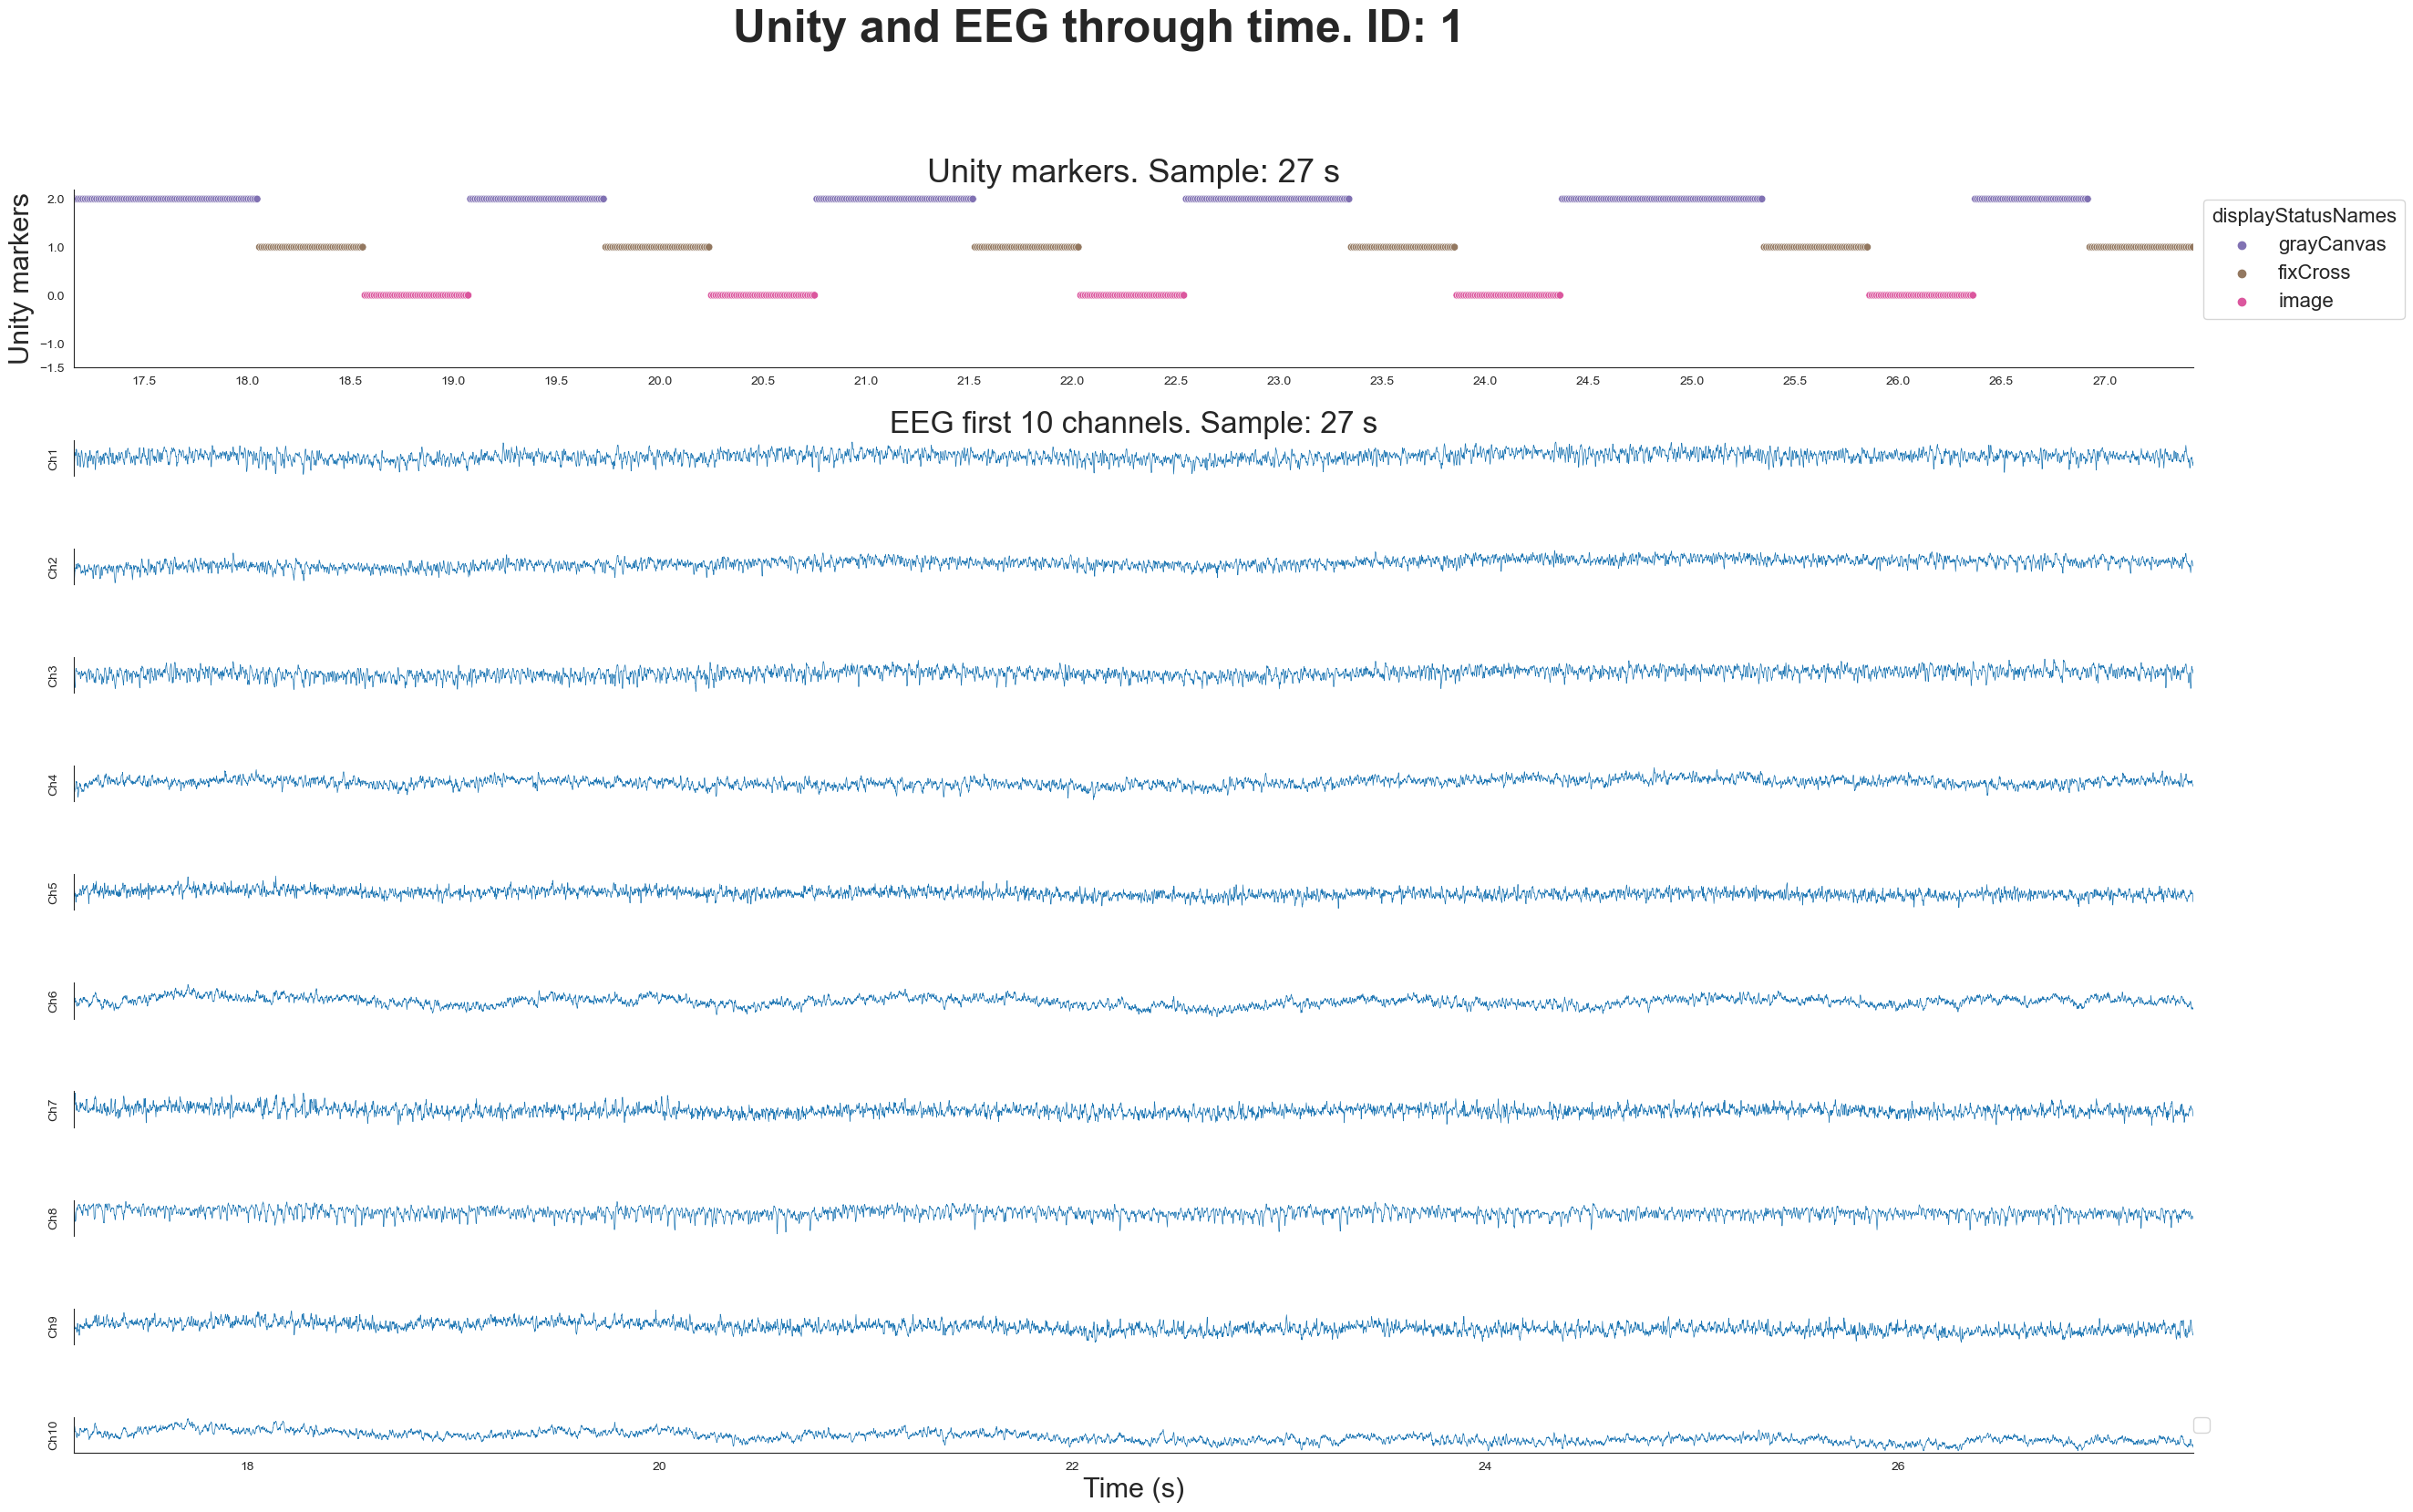

In [25]:
# df_unity_vis = df_dis_renamed[df_dis_renamed['shiftID'] < 16]
visualize_unity_eeg(df_renamed2, df_eeg_all, id='1', display_start=16, display_end=32, save=False)

In [26]:
# quick statistics to know if all rows have same length
df_eeg.describe()
# df['HON_HitObjectNames'].isnull().sum()
# df['HON_HitObjectNames'].unique()

,Ch1,Ch2,Ch3,Ch4,Ch5,Ch6,Ch7,Ch8,Ch9,Ch10,timestamps
count,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000
mean,-2466.572266,-6345.822754,-4174.313477,-2627.739990,-691.317322,-1507.328125,-4047.843506,351.516876,-188.029190,-3399.825195,2.999512
std,23.605917,23.183710,22.987413,11.525866,14.039415,13.053369,15.590211,16.329668,9.982818,6.802493,1.732192
min,-2546.242676,-6438.835449,-4278.102539,-2663.129395,-747.976440,-1537.220093,-4106.891602,273.790314,-218.270905,-3422.820312,0.000000
25%,-2482.728210,-6362.222656,-4189.062744,-2635.029541,-700.511902,-1517.818604,-4058.328125,341.667816,-194.934006,-3404.411865,1.499756
50%,-2467.036865,-6346.885254,-4173.279297,-2628.657349,-691.463989,-1508.265015,-4048.190674,353.759232,-189.012421,-3400.053467,2.999512
75%,-2450.633057,-6330.109131,-4158.401855,-2622.174805,-682.140259,-1497.387329,-4038.126770,363.239288,-182.428802,-3395.069824,4.499268
max,-2384.281982,-6274.465820,-4102.551270,-2575.666504,-619.816528,-1471.604614,-3979.430420,394.189636,-141.419098,-3373.627197,5.999023


### 2.2 Eye-tracking streams into DataFrame
Given all eye-tracking related streams have a different length than the "ImageInfo" stream, we create a separate DF using the same function we created for the "ImageInfo" stream data.

In [27]:
# inspect the eye_tracking data
df_eye = get_streams_data(streams, streams_keep=['HitObjectNames', 'HitPositionOnObjects','HeadTracking','EyeTrackingWorld','EyeTrackingLocal'])
df_eye


Participant UID: f8780dc1-6310-4759-9d7b-a59548ab6397
Streams to keep: ['EyeTrackingLocal', 'HitObjectNames', 'HeadTracking', 'EyeTrackingWorld', 'HitPositionOnObjects'] and reference stream ['openvibeSignal']
openvibeSignal start time is 532357.7540644857 and end time is 536241.6905890936
Unity start time is 532365.8753896048 and end time is 536234.3221074663
 !! Unity delayed recording start by 8.121325119165704 seconds detected
 -- Unity EyeTrackingLocal start time is 532365.8764726362 and end time is 536234.3221039784
 -- Unity HitObjectNames start time is 532365.8764168626 and end time is 536234.3220973094
 -- Unity HeadTracking start time is 532365.8765792161 and end time is 536234.3221074663
 -- Unity EyeTrackingWorld start time is 532365.8753896048 and end time is 536234.3220511132
 -- Unity HitPositionOnObjects start time is 532365.8764236135 and end time is 536234.3220994344
 -- All Unity streams start time difference is 1.2 (milliseconds)
 -- All Unity streams end time diff

,uid,HON_HitObjectNames,time_stamps_HitObjectNames,corrected_tstamps_HitObjectNames,normalized_tstamps_HitObjectNames,HPOOX_HitPositionOnObjects,HPOOY_HitPositionOnObjects,HPOOZ_HitPositionOnObjects,time_stamps_HitPositionOnObjects,corrected_tstamps_HitPositionOnObjects,...,normalized_tstamps_EyeTrackingWorld,ETLoriginX_EyeTrackingLocal,ETLoriginY_EyeTrackingLocal,ETLoriginZ_EyeTrackingLocal,ETLdirectionX_EyeTrackingLocal,ETLdirectionY_EyeTrackingLocal,ETLdirectionZ_EyeTrackingLocal,time_stamps_EyeTrackingLocal,corrected_tstamps_EyeTrackingLocal,normalized_tstamps_EyeTrackingLocal
0,f8780dc1-6310-4759-9d7b-a59548ab6397,DisplayCanvas,532365.876417,532365.876417,8.122352,-1.104202,2.057868,9.900000,532365.876424,532365.876424,...,8.132055,-0.000250,-0.000925,-0.029049,0.072647,0.054749,0.995850,532365.876473,532365.876473,8.122408
1,f8780dc1-6310-4759-9d7b-a59548ab6397,DisplayCanvas,532365.886167,532365.886188,8.132124,-1.105965,2.059422,9.900000,532365.886169,532365.886191,...,8.143178,-0.000403,-0.000924,-0.029060,0.072571,0.054932,0.995834,532365.886174,532365.886195,8.132131
2,f8780dc1-6310-4759-9d7b-a59548ab6397,DisplayCanvas,532365.897267,532365.897309,8.143244,-1.106005,2.060409,9.900000,532365.897268,532365.897310,...,8.154390,-0.000503,-0.000923,-0.029065,0.072617,0.055038,0.995834,532365.897272,532365.897314,8.143250
3,f8780dc1-6310-4759-9d7b-a59548ab6397,DisplayCanvas,532365.908480,532365.908544,8.154479,-1.104038,2.061731,9.900000,532365.908484,532365.908547,...,8.165390,-0.000116,-0.000928,-0.029037,0.072769,0.055176,0.995819,532365.908489,532365.908552,8.154488
4,f8780dc1-6310-4759-9d7b-a59548ab6397,DisplayCanvas,532365.919435,532365.919519,8.165455,-1.104236,2.066259,9.900000,532365.919438,532365.919522,...,8.176504,0.000208,-0.000932,-0.029016,0.072693,0.055557,0.995804,532365.919442,532365.919527,8.165462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267779,f8780dc1-6310-4759-9d7b-a59548ab6397,FixationCollider,536234.266548,536241.634924,3883.880860,0.285734,1.444636,9.398259,536234.266551,536241.634927,...,3883.891883,-0.000393,0.002750,-0.031355,0.082901,0.017761,0.996384,536234.266556,536241.634932,3883.880868
267780,f8780dc1-6310-4759-9d7b-a59548ab6397,FixationCollider,536234.277597,536241.645994,3883.891929,0.284841,1.444454,9.397733,536234.277599,536241.645996,...,3883.903157,-0.000321,0.002750,-0.031350,0.082794,0.017776,0.996399,536234.277604,536241.646001,3883.891937
267781,f8780dc1-6310-4759-9d7b-a59548ab6397,FixationCollider,536234.288850,536241.657268,3883.903203,0.287044,1.445179,9.399199,536234.288852,536241.657271,...,3883.914187,-0.000147,0.002749,-0.031336,0.083008,0.017868,0.996384,536234.288858,536241.657276,3883.903211
267782,f8780dc1-6310-4759-9d7b-a59548ab6397,FixationCollider,536234.299866,536241.668306,3883.914241,0.290322,1.445200,9.400790,536234.299869,536241.668308,...,3883.925317,-0.000158,0.002749,-0.031336,0.083313,0.017899,0.996353,536234.299874,536241.668314,3883.914249


In [28]:
# check no NaN in dataset
df_eye.isnull().sum()

uid                                        0
HON_HitObjectNames                         0
time_stamps_HitObjectNames                 0
corrected_tstamps_HitObjectNames           0
normalized_tstamps_HitObjectNames          0
HPOOX_HitPositionOnObjects                 0
HPOOY_HitPositionOnObjects                 0
HPOOZ_HitPositionOnObjects                 0
time_stamps_HitPositionOnObjects           0
corrected_tstamps_HitPositionOnObjects     0
normalized_tstamps_HitPositionOnObjects    0
HToriginX_HeadTracking                     0
HToriginY_HeadTracking                     0
HToriginZ_HeadTracking                     0
HTdirectionX_HeadTracking                  0
HTdirectionY_HeadTracking                  0
HTdirectionZ_HeadTracking                  0
time_stamps_HeadTracking                   0
corrected_tstamps_HeadTracking             0
normalized_tstamps_HeadTracking            0
ETWTime_EyeTrackingWorld                   0
ETWoriginX_EyeTrackingWorld                0
ETWoriginY

In [29]:
df_eye_start = df_eye.head(2700)
df_eye_start

,uid,HON_HitObjectNames,time_stamps_HitObjectNames,corrected_tstamps_HitObjectNames,normalized_tstamps_HitObjectNames,HPOOX_HitPositionOnObjects,HPOOY_HitPositionOnObjects,HPOOZ_HitPositionOnObjects,time_stamps_HitPositionOnObjects,corrected_tstamps_HitPositionOnObjects,...,normalized_tstamps_EyeTrackingWorld,ETLoriginX_EyeTrackingLocal,ETLoriginY_EyeTrackingLocal,ETLoriginZ_EyeTrackingLocal,ETLdirectionX_EyeTrackingLocal,ETLdirectionY_EyeTrackingLocal,ETLdirectionZ_EyeTrackingLocal,time_stamps_EyeTrackingLocal,corrected_tstamps_EyeTrackingLocal,normalized_tstamps_EyeTrackingLocal
0,f8780dc1-6310-4759-9d7b-a59548ab6397,DisplayCanvas,532365.876417,532365.876417,8.122352,-1.104202,2.057868,9.900000,532365.876424,532365.876424,...,8.132055,-0.000250,-0.000925,-0.029049,0.072647,0.054749,0.995850,532365.876473,532365.876473,8.122408
1,f8780dc1-6310-4759-9d7b-a59548ab6397,DisplayCanvas,532365.886167,532365.886188,8.132124,-1.105965,2.059422,9.900000,532365.886169,532365.886191,...,8.143178,-0.000403,-0.000924,-0.029060,0.072571,0.054932,0.995834,532365.886174,532365.886195,8.132131
2,f8780dc1-6310-4759-9d7b-a59548ab6397,DisplayCanvas,532365.897267,532365.897309,8.143244,-1.106005,2.060409,9.900000,532365.897268,532365.897310,...,8.154390,-0.000503,-0.000923,-0.029065,0.072617,0.055038,0.995834,532365.897272,532365.897314,8.143250
3,f8780dc1-6310-4759-9d7b-a59548ab6397,DisplayCanvas,532365.908480,532365.908544,8.154479,-1.104038,2.061731,9.900000,532365.908484,532365.908547,...,8.165390,-0.000116,-0.000928,-0.029037,0.072769,0.055176,0.995819,532365.908489,532365.908552,8.154488
4,f8780dc1-6310-4759-9d7b-a59548ab6397,DisplayCanvas,532365.919435,532365.919519,8.165455,-1.104236,2.066259,9.900000,532365.919438,532365.919522,...,8.176504,0.000208,-0.000932,-0.029016,0.072693,0.055557,0.995804,532365.919442,532365.919527,8.165462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,f8780dc1-6310-4759-9d7b-a59548ab6397,FixationCollider,532395.817109,532395.874145,38.120081,-0.428624,1.631114,9.689041,532395.817113,532395.874148,...,38.131060,0.006144,-0.000964,-0.028879,-0.008209,0.045502,0.998917,532395.817117,532395.874153,38.120088
2696,f8780dc1-6310-4759-9d7b-a59548ab6397,FixationCollider,532395.828156,532395.885213,38.131148,-0.579342,1.500563,9.742257,532395.828160,532395.885217,...,38.142175,-0.018979,-0.000749,-0.030331,-0.020996,0.036194,0.999115,532395.828165,532395.885222,38.131157
2697,f8780dc1-6310-4759-9d7b-a59548ab6397,DisplayCanvas,532395.839247,532395.896325,38.142260,-0.702947,1.480090,9.900000,532395.839251,532395.896329,...,38.153430,-0.025152,-0.000754,-0.030466,-0.032135,0.036392,0.998810,532395.839256,532395.896334,38.142269
2698,f8780dc1-6310-4759-9d7b-a59548ab6397,DisplayCanvas,532395.850465,532395.907565,38.153500,-0.675421,1.428253,9.900000,532395.850468,532395.907567,...,38.164465,-0.028196,-0.000755,-0.030556,-0.029144,0.032547,0.999039,532395.850473,532395.907572,38.153508


In [30]:
def visualize_eye(df, id='', save=True):
    # take a sample for 30 seconds of recording (30s x 90fps = 2700 datapoints)
    df_eye_start = df.head(2700)

    plt.rcParams.update({'font.size': 14})
    # rename the columns of interest
    eye_selected = df_eye_start[["normalized_tstamps_EyeTrackingWorld","HTdirectionX_HeadTracking", "HTdirectionY_HeadTracking","HTdirectionZ_HeadTracking","ETWdirectionX_EyeTrackingWorld", "ETWdirectionY_EyeTrackingWorld","ETWdirectionZ_EyeTrackingWorld"]].rename(columns={"HTdirectionX_HeadTracking": "HTdirectionX", "HTdirectionY_HeadTracking": "HTdirectionY","HTdirectionZ_HeadTracking":"HTdirectionZ","ETWdirectionX_EyeTrackingWorld": "ETdirectionX", "ETWdirectionY_EyeTrackingWorld": "ETdirectionY","ETWdirectionZ_EyeTrackingWorld":"ETdirectionZ"})
    # covert the dataframe to be tidy (long and not wide format)
    df_eye_tidy = eye_selected.melt('normalized_tstamps_EyeTrackingWorld', var_name="cols",value_name='vals')

    # create the subplots
    fig, ax = plt.subplots(nrows=3, figsize=(20, 8), sharex=True)
    fig.suptitle("Head and eye axis' directions through time. Sample "+str(round(df_eye_tidy['normalized_tstamps_EyeTrackingWorld'].max()))+" s. ID: " + id, fontsize=22, y=0.93, fontweight='bold')
    x = sns.lineplot(x="normalized_tstamps_EyeTrackingWorld", y='vals', hue='cols', data=df_eye_tidy[df_eye_tidy['cols'].str.contains('X')], style='cols', ax=ax[0], linewidth=3)
    ax[0].set_ylim(-1,1)
    ax[0].set_ylabel("X coordinate", fontsize=16)
    ax[0].set_xlim(0,df_eye_tidy['normalized_tstamps_EyeTrackingWorld'].max())
    x.legend_.set_title(None)

    y = sns.lineplot(x="normalized_tstamps_EyeTrackingWorld", y='vals', hue='cols', data=df_eye_tidy[df_eye_tidy['cols'].str.contains('Y')], style='cols', ax=ax[1], linewidth=3)
    ax[1].set_ylim(-1,1)
    ax[1].set_xlim(0,df_eye_tidy['normalized_tstamps_EyeTrackingWorld'].max())
    ax[1].set_ylabel("Y coordinate", fontsize=16)
    y.legend_.set_title(None)
    z = sns.lineplot(x="normalized_tstamps_EyeTrackingWorld", y='vals', hue='cols', data=df_eye_tidy[df_eye_tidy['cols'].str.contains('Z')], style='cols', ax=ax[2], linewidth=3)
    ax[2].set_ylim(-1,1)
    ax[2].set_xlim(0,df_eye_tidy['normalized_tstamps_EyeTrackingWorld'].max())
    z.legend_.set_title(None)
    ax[2].set_ylabel("Z coordinate", fontsize=16)
    ax[2].set_xlabel("Time (s)", fontsize=16)
    ax[2].locator_params(axis='x', nbins=30)
    plt.tight_layout()
    sns.despine(top=True, bottom=False)
    if save:
        plt.savefig("data/images/" + "axis_directions_" + str(round(df_eye_tidy['normalized_tstamps_EyeTrackingWorld'].max())) + '_'+ id + ".pdf", format='pdf',bbox_inches='tight', dpi=1200)

    del df_eye_start, eye_selected, df_eye_tidy

**Eye-tracking analysis for data recording 46:**
The starting time here corresponds to the time unity started collecting samples from the 'Visual' stream which is constantly sending samples to LabRecorder.  When visualizing the eye tracking data we can notice that the fist eye data samples collected start at around 60 seconds from the  time the LabRecorder was started. Previous to that, there is no data being collected which is how the experiment was designed. This is corroborated by the fact that the initial 'Display status name" in the infoName stream corresponds to the 'startMessage" (see image "display status" image).

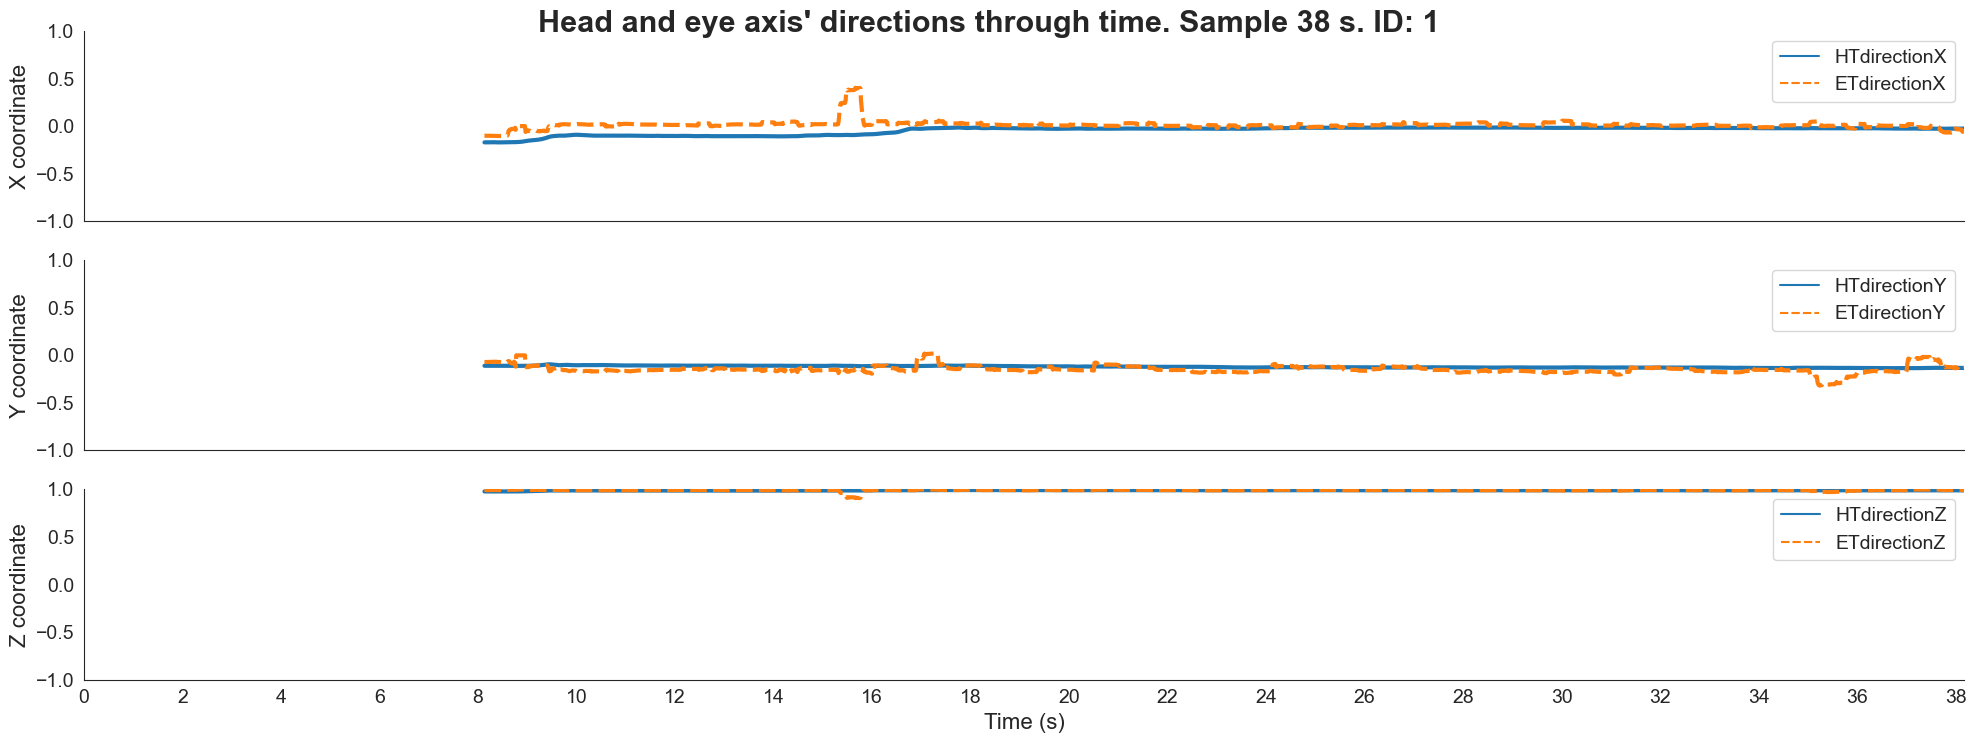

In [31]:
visualize_eye(df=df_eye, id='1', save=False)

### 2.3 Join ImageInfo DataFrame with eye DataFrame
So far we have created two different dataframes:
- ImageInfo df: contains all Unity streams that send data into the system independent of eye tracking (e.g, 'ImageInfo', 'Visual')
- Eye df: containing all Unity streams info that depend on eye-tracking (e.g., 'HitOnObjectNames')
For this reason, both df have different length, the first one having the largest amount of datapoints a.k.a. rows. To be able to separate the images that were actually seen from those that were not, we join both DataFrames based on the timestamps.
-- We detect when the first eye-tracking timestamp matches a timestamp un the ImageInfo df, so we join them from then on.

In [32]:
def merge_img_eye_streams_data(img_df, eye_df):
    # create a common timestamp column for each df from the time-related columns to be merged
    img_df['merged_ts'] = img_df["time_stamps_ImageInfo"]
    #print(df_renamed2.columns)
    eye_df['merged_ts'] = eye_df["time_stamps_HitObjectNames"]
    # drop shared column
    eye_df2 = eye_df.drop('uid', axis=1)
    # merge both df based on the common column, specifying the tolerance will not allow times to be to far apart
    merged_eye_img_df = pd.merge_asof(img_df, eye_df2, on='merged_ts', tolerance=0.01)
    merged_eye_img_df

    ### CALCULATE VALID CENTERED FIXATIONS ###
    grouped_unique = merged_eye_img_df.groupby(['blockNumber_ImageInfo','shiftID','imageName_ImageInfo','HON_HitObjectNames'])['normalized_tstamps_ImageInfo'].nunique().reset_index().rename(columns={'normalized_tstamps_ImageInfo': 'centered_fixations'})
    grouped_unique = grouped_unique[(grouped_unique['imageName_ImageInfo'] != 'grayCanvas') & (grouped_unique['imageName_ImageInfo'] != 'fixationCross') & (grouped_unique['imageName_ImageInfo'] != 'startMessage')& (grouped_unique['imageName_ImageInfo'] != 'endMessage')]
    sumpergroup = grouped_unique.groupby(['blockNumber_ImageInfo','shiftID','imageName_ImageInfo']).sum('HON_HitObjectNames').reset_index().rename(columns={'centered_fixations': 'total_fixations'})
    merge = pd.merge(grouped_unique, sumpergroup, on=['blockNumber_ImageInfo','shiftID','imageName_ImageInfo'], how='left')
    # valid fixation when the total hit on fixation collider > 70 %
    merge['valid_fixation'] = merge.apply(lambda x: True if x['centered_fixations']/x['total_fixations'] > 0.7 else False, axis=1)
    merge = merge[merge['HON_HitObjectNames'] == 'FixationCollider']
    merge.drop('HON_HitObjectNames', axis=1, inplace=True)
    merge

    df_eye_img2 = pd.merge(merged_eye_img_df, merge, on=['blockNumber_ImageInfo','shiftID','imageName_ImageInfo'], how='left')

    del eye_df2, merged_eye_img_df, grouped_unique, sumpergroup, merge
    return df_eye_img2

In [33]:
merged_img_eye_df = merge_img_eye_streams_data(df_renamed2,df_eye)
merged_img_eye_df

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,normalized_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,...,ETLoriginZ_EyeTrackingLocal,ETLdirectionX_EyeTrackingLocal,ETLdirectionY_EyeTrackingLocal,ETLdirectionZ_EyeTrackingLocal,time_stamps_EyeTrackingLocal,corrected_tstamps_EyeTrackingLocal,normalized_tstamps_EyeTrackingLocal,centered_fixations,total_fixations,valid_fixation
0,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.012002,532358.012002,0.257938,6713.0,-1.0,116.868523,532358.011998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.022943,532358.022950,0.268885,6714.0,-1.0,116.879471,532358.022940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.034062,532358.034076,0.280011,6715.0,-1.0,116.890587,532358.034058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.045174,532358.045194,0.291130,6716.0,-1.0,116.901688,532358.045168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.056291,532358.056319,0.302254,6717.0,-1.0,116.912811,532358.056287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337005,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.264204,536241.646129,3883.892064,343751.0,99.0,3998.127930,536239.264201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
337006,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.275274,536241.657205,3883.903141,343752.0,99.0,3998.138916,536239.275271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
337007,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.286626,536241.668564,3883.914500,343753.0,99.0,3998.150391,536239.286622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
337008,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.297521,536241.679466,3883.925402,343754.0,99.0,3998.161377,536239.297519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Creating Trigger Files
- For each initial time an image was shown, we want to keep the type of object it was (i.e., face, object, body) as a separate column.
- Additional triggers contain the rotation and distance the specific object was with respect to the player at the time the free-viewing walk took place.
- __Note:__ We want the triggers only once to denote the initial time the image was shown.

In [34]:
def create_triggers(df):
    # save the names of the object, body or face shown in the image
    df['ob_names'] =  df.apply(lambda x: x["imageName_ImageInfo"].split(".")[5] if len(x["imageName_ImageInfo"].split(".")) > 7 else '', axis=1)
    # create the triggers to mark the start of image displaying
    # check when there is a change from image, canvas, fixationCross
    df['shift'] = df['imageName_ImageInfo'].shift(1) != df['imageName_ImageInfo']
    # save the starting time (aka 'latency') when image is displayed
    df['latency'] = df.apply(lambda x: x['normalized_tstamps_ImageInfo'] if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    # save the type of image displaying (face, object, body)
    df['type'] = df.apply(lambda x: 'face' if x['shift'] and 'face' in x['imageName_ImageInfo'].lower()
                                            else ('body' if x['shift'] and 'npc' in x['imageName_ImageInfo'].lower()
                                            else ('object' if x['shift'] and 'rotation' in x['imageName_ImageInfo'].lower()
                                            and 'face|npc' not in x['imageName_ImageInfo'].lower()
                                            else '')), axis=1)
    # save if it is valid or invalid fixation (that is, if person was looking to the center
    df['valid'] = df.apply(lambda x: 1 if x['valid_fixation'] == True else 0, axis=1)
    # define the triggers for rotation, distance, and block
    df['rotation'] = df.apply(lambda x: x["imageName_ImageInfo"].split(".")[7] if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    df['distance'] = df.apply(lambda x: x["imageName_ImageInfo"].split(".")[9] if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    df['block'] = df.apply(lambda x: str(x["blockNumber_ImageInfo"]) if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    # select the trigger columns and non empty rows
    df_sel = df[['latency','type','valid','rotation','distance','block']]
    df_triggers = df_sel[df_sel['latency'] != '']
    # save first uid for later usage
    uid = df['uid'][0]
    del df_sel
    return df, df_triggers, uid

In [35]:
df, df_triggers, uid = create_triggers(merged_img_eye_df)
df_triggers

,latency,type,valid,rotation,distance,block
852,9.726232,face,1,54,3,0
1026,11.659936,face,1,11,4,0
1171,13.271228,face,1,70,6,0
1327,15.016206,object,0,122,10,0
1474,16.649466,body,0,5,1,0
...,...,...,...,...,...,...
335878,3871.356952,body,1,140,6,3
336022,3872.957275,face,1,12,4,3
336186,3874.779939,object,1,122,10,3
336368,3876.802336,face,1,7,1,3


In [36]:
df

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,normalized_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,...,centered_fixations,total_fixations,valid_fixation,ob_names,latency,type,valid,rotation,distance,block
0,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.012002,532358.012002,0.257938,6713.0,-1.0,116.868523,532358.011998,...,NaN,NaN,NaN,,,,0,,,
1,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.022943,532358.022950,0.268885,6714.0,-1.0,116.879471,532358.022940,...,NaN,NaN,NaN,,,,0,,,
2,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.034062,532358.034076,0.280011,6715.0,-1.0,116.890587,532358.034058,...,NaN,NaN,NaN,,,,0,,,
3,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.045174,532358.045194,0.291130,6716.0,-1.0,116.901688,532358.045168,...,NaN,NaN,NaN,,,,0,,,
4,f8780dc1-6310-4759-9d7b-a59548ab6397,0,startMessage,532358.056291,532358.056319,0.302254,6717.0,-1.0,116.912811,532358.056287,...,NaN,NaN,NaN,,,,0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337005,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.264204,536241.646129,3883.892064,343751.0,99.0,3998.127930,536239.264201,...,NaN,NaN,NaN,,,,0,,,
337006,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.275274,536241.657205,3883.903141,343752.0,99.0,3998.138916,536239.275271,...,NaN,NaN,NaN,,,,0,,,
337007,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.286626,536241.668564,3883.914500,343753.0,99.0,3998.150391,536239.286622,...,NaN,NaN,NaN,,,,0,,,
337008,f8780dc1-6310-4759-9d7b-a59548ab6397,3,endMessage,536239.297521,536241.679466,3883.925402,343754.0,99.0,3998.161377,536239.297519,...,NaN,NaN,NaN,,,,0,,,


In [37]:
def valid_images(df):
    img_unique = df[~df['imageName_ImageInfo'].str.contains('fixation|grayCan|Message')]
    total_images = img_unique.groupby('blockNumber_ImageInfo')['imageName_ImageInfo'].nunique().reset_index().rename(columns={"blockNumber_ImageInfo": "block_number", "imageName_ImageInfo": "total_img"})

    # convert column to numeric to drop the duplicates correctly
    total_images['block_number'] = pd.to_numeric(total_images['block_number'])

    img_validity_array = img_unique[img_unique['shift']].groupby(['blockNumber_ImageInfo','valid'])['time_stamps_ImageInfo'].nunique().reset_index()
    # img_validity_array
    valid = img_validity_array[img_validity_array['valid'] == 1][['blockNumber_ImageInfo', 'time_stamps_ImageInfo']].rename(columns={'blockNumber_ImageInfo': 'block_number', 'time_stamps_ImageInfo': 'valid'}).astype('int64')
    invalid = img_validity_array[img_validity_array['valid'] == 0][['blockNumber_ImageInfo', 'time_stamps_ImageInfo']].rename(columns={'blockNumber_ImageInfo': 'block_number', 'time_stamps_ImageInfo': 'invalid'}).astype('int64')
    total_images = pd.merge(total_images, valid, how='left', on=['block_number'])
    total_images = pd.merge(total_images, invalid, how='left', on=['block_number'])
    del img_validity_array, valid, invalid

    return total_images

In [38]:
valid_images(df)

,block_number,total_img,valid,invalid
0,0,210,346,73
1,1,210,297,123
2,2,210,333,87
3,3,210,355,66


## 4 Complete visualization
Let's visualise Unity and EEG streams in one single plot

In [51]:
def visualize_unity_eeg_all(unity_df, eeg_df,time_fragment='', id='', display_start=0,display_end=16, vis_end=False, shifts_from_end=16, save=True):
    # when visualizing the end of the recording
    if vis_end:
        # find the last shift in the dataframe
        display_end = unity_df['shiftID'].iloc[-1]
        # calculate amount of shift to display from the end
        display_start = display_end - shifts_from_end
        # keep only data in dataframe that is between desired start and end to be visualized
        unity_df_sel = unity_df[unity_df['shiftID'].between(display_start,display_end)]
        # replace ending display nummber '99' for -0.5 to allow plot in y-axis
        unity_df2 = unity_df_sel.replace({'displayStatus_Visual':99},-1)
    else:
        # select the first 16 shifts in the data
        unity_df2 = unity_df[unity_df['shiftID'].between(display_start,display_end)]

    start_time = unity_df2['normalized_tstamps_ImageInfo'].min()
    end_time = unity_df2['normalized_tstamps_ImageInfo'].max()

    # set the color palette
    # colors = dict(startMessage=deep_pal[6], fixCross=deep_pal[4], image=deep_pal[0], grayCanvas=deep_pal[1])

    fig = plt.figure(figsize=(26, 22))
    plt.rcParams.update({'font.size': 18})
    if vis_end:
        fig.suptitle("Unity and EEG streams at end of recording time. ID: " + id, fontsize=32, y=0.94, fontweight='bold')
    else:
        if display_start <= 0:
            fig.suptitle("Unity and EEG streams at start of recording time. ID: " + id, fontsize=32, y=0.94, fontweight='bold')
        else:
            fig.suptitle("Unity and EEG streams through recording time. ID: " + id, fontsize=32, y=0.94, fontweight='bold')
    # make outer gridspec of 3 rows and 1 column
    outer = fig.add_gridspec(3, 1, hspace = .2, height_ratios = [8, 4, 16])

    # make nested gridspecs
    inner_grid1 = outer[0, 0].subgridspec(3, 1, hspace=0.05)
    inner_grid2 = fig.add_subplot(outer[1, 0])
    inner_grid3 = outer[2, 0].subgridspec(10, 1, hspace=0)

    ### Visualize EYE data ###
    eye_selected = unity_df[["normalized_tstamps_EyeTrackingWorld","HTdirectionX_HeadTracking", "HTdirectionY_HeadTracking","HTdirectionZ_HeadTracking","ETWdirectionX_EyeTrackingWorld", "ETWdirectionY_EyeTrackingWorld","ETWdirectionZ_EyeTrackingWorld"]].rename(columns={"HTdirectionX_HeadTracking": "HTdirectionX", "HTdirectionY_HeadTracking": "HTdirectionY","HTdirectionZ_HeadTracking":"HTdirectionZ","ETWdirectionX_EyeTrackingWorld": "ETdirectionX", "ETWdirectionY_EyeTrackingWorld": "ETdirectionY","ETWdirectionZ_EyeTrackingWorld":"ETdirectionZ"})
    # covert the dataframe to be tidy (long and not wide format)
    df_eye_tidy = eye_selected.melt('normalized_tstamps_EyeTrackingWorld', var_name="cols",value_name='vals')

    def eyeviz(axx, dimension):
        dim = sns.lineplot(x="normalized_tstamps_EyeTrackingWorld", y='vals', hue='cols', data=df_eye_tidy[df_eye_tidy['cols'].str.contains(dimension)], style='cols', ax=axx, linewidth=4)
        if dimension == 'X':
            axx.set_title("Eye-tracking. Sample: " + str(round(end_time-start_time)) + ' s', fontsize=28)
        if dimension == 'Z':
            axx.set_xlabel('', fontsize=22)
            # axx.set_ylim(-1,1.1) # set y-axis limits if needed
        else:
            axx.set_xticks([])
            axx.set(xlabel=None)
        # axx.spines.top.set_visible(False) # set top, left, right lines visible
        axx.set_ylabel(dimension + " axis", fontsize=22)
        axx.set_xlim(start_time-0.013,end_time)
        ## change legends' lines size
        # obtain the handles and labels from the figure
        handles, labels = axx.get_legend_handles_labels()
        # copy the handles
        handles = [copy.copy(ha) for ha in handles ]
        # set the linewidths to the copies
        [ha.set_linewidth(4) for ha in handles ]
        # put the copies into the legend
        axx.legend(title='HT vs. ET', title_fontsize='20', handles=handles, labels=labels,bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=.05)

    # plot head vs. eye tracking axis in its own gridspecc
    for i, ax in enumerate(inner_grid1.subplots()):
        eyeviz(ax, chr(88 + i)) # Ord 88 = 'X', Ord 89 = 'Y' etc.

    def unityviz(axx):
        hue_lab = unity_df2['displayStatusNames'].unique().tolist()
        # choose the hue labels based on start or end plotting
        if 'startMessage' in hue_lab:
            hue_order = ['grayCanvas','fixCross','image', 'startMessage']
        else: hue_order =['grayCanvas','fixCross','image', 'endMessage']
        # visualize displayStatuses
        sns.scatterplot(x=unity_df2['normalized_tstamps_ImageInfo'], y=unity_df2['displayStatus_Visual'], data=unity_df2, hue='displayStatusNames', palette=colors, s=110, hue_order=hue_order,ax=axx)
        axx.set_ylim(-1.2, 2.2)
        axx.set_xlim(start_time - 0.013,end_time)
        axx.set_yticks([-1, 0, 1, 2])
        axx.locator_params(axis='both', nbins=33)
        axx.legend(title='Display status',title_fontsize='22',bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=.05)
        #axx.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=.0)
        axx.set_title("Unity markers. Sample: " + str(round(end_time - start_time)) + ' s', fontsize=28)
        axx.set_xlabel('', fontsize=16)
        axx.set_ylabel('Unity markers', fontsize=22)

    # visualize Unity displays statuses
    unityviz(inner_grid2)

    # normalize eeg time_stamps to start from zero
    eeg_df['timestamps'] = eeg_df['timestamps'] - eeg_df['timestamps'][0]
    eeg_df = eeg_df[eeg_df['timestamps'].between(start_time,end_time)]
    # select latencies to set stimulus onset
    labels = unity_df2[unity_df2['type'] !='']
    list_labels = labels['type'].values.tolist()
    # select valid gazes >70%
    valid_lab = labels['valid'].replace([1,0],['valid','invalid']).values.tolist()

    latencies = unity_df2[unity_df2['latency'] !='']
    list_lat = latencies['latency'].values.tolist()

    def eegviz(axx, i, first = False, last = False):
        g = sns.lineplot(x= eeg_df['timestamps'], y = eeg_df[eeg_df.columns[i]],ax=axx, linewidth=0.1)
        axx.set(yticklabels=[])
        axx.set_xlim(eeg_df['timestamps'].min(),eeg_df['timestamps'].max())
        axx.spines.top.set_visible(False)
        axx.set_ylabel('Ch'+str(i+1), fontsize=20)
        for lat_i, lat_value in enumerate(list_lat):
            # create a vertical line with diff. color per category indicating the stimulus onset
            if list_labels[lat_i] == 'face':
                g.vlines(x=lat_value, ymin=eeg_df[eeg_df.columns[i]].min(),ymax=eeg_df[eeg_df.columns[i]].max(), colors="#D0465A",label=list_labels[lat_i], ls='solid', lw=4)
            if list_labels[lat_i] == 'body':
                g.vlines(x=lat_value, ymin=eeg_df[eeg_df.columns[i]].min(),ymax=eeg_df[eeg_df.columns[i]].max(), colors="#C99756",label=list_labels[lat_i], ls='dashed', lw=4)
            if list_labels[lat_i] == 'object':
                g.vlines(x=lat_value, ymin=eeg_df[eeg_df.columns[i]].min(),ymax=eeg_df[eeg_df.columns[i]].max(), colors="#046378",label=list_labels[lat_i], ls='dotted', lw=4)

        if last:
            axx.set_xlabel('Time (s)', fontsize=24)
        else:
            if first:
                # annotate valid/invalid triggers
                for lat_i, lat_value in enumerate(list_lat):
                    y_loc = round(eeg_df[eeg_df.columns[i]].min() + eeg_df[eeg_df.columns[i]].max()) / 2
                    axx.text(lat_value,y_loc, str(valid_lab[lat_i]), bbox=dict(boxstyle="round", edgecolor='black', fc="0.94"))
                # include legend
                axx.legend(title='Category',title_fontsize='22',bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=.05)
                axx.set_title("EEG with triggers for first 10 channels. Sample: " + str(round(end_time-start_time)) + ' s', fontsize=28)
                axx.spines.top.set_visible(True)
                # do not repeat label names in legend
                handles, labels = axx.get_legend_handles_labels()
                by_label = OrderedDict(zip(labels, handles))
                axx.legend(by_label.values(), by_label.keys(),title='Category',fontsize='20',title_fontsize='22', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=.05)
            axx.set_xticks([])
            axx.set_xlabel('', fontsize=22)
            axx.spines.bottom.set_visible(False)

    # plot every column from eeg df into a single gridspec
    for i, ax in enumerate(inner_grid3.subplots()):
        eegviz(ax, i, i == 0, i == len(eeg_df.columns) - 2)
    # save image
    if save and vis_end:
        plt.savefig("data/images/" + "displayStatusNEW_end_from_"+ str(round(start_time)) +"s_to_"+ str(round(end_time)) + 's_'+ id + ".pdf", format='pdf',bbox_inches='tight', dpi=1200)
    else:
        if save and display_start <= 0:
            plt.savefig("data/images/" + "displayStatusNEW_start_from_"+ str(round(start_time)) +"s_to_"+ str(round(end_time)) + 's_'+ id + ".pdf", format='pdf',bbox_inches='tight', dpi=1200)
        else:
            plt.savefig("data/images/" + "displayStatusNEW_through_time_from_"+ str(round(start_time)) +"s_to_"+ str(round(end_time)) + 's_'+ id + ".pdf", format='pdf',bbox_inches='tight', dpi=1200)

    del unity_df2, latencies, labels, list_labels, valid_lab

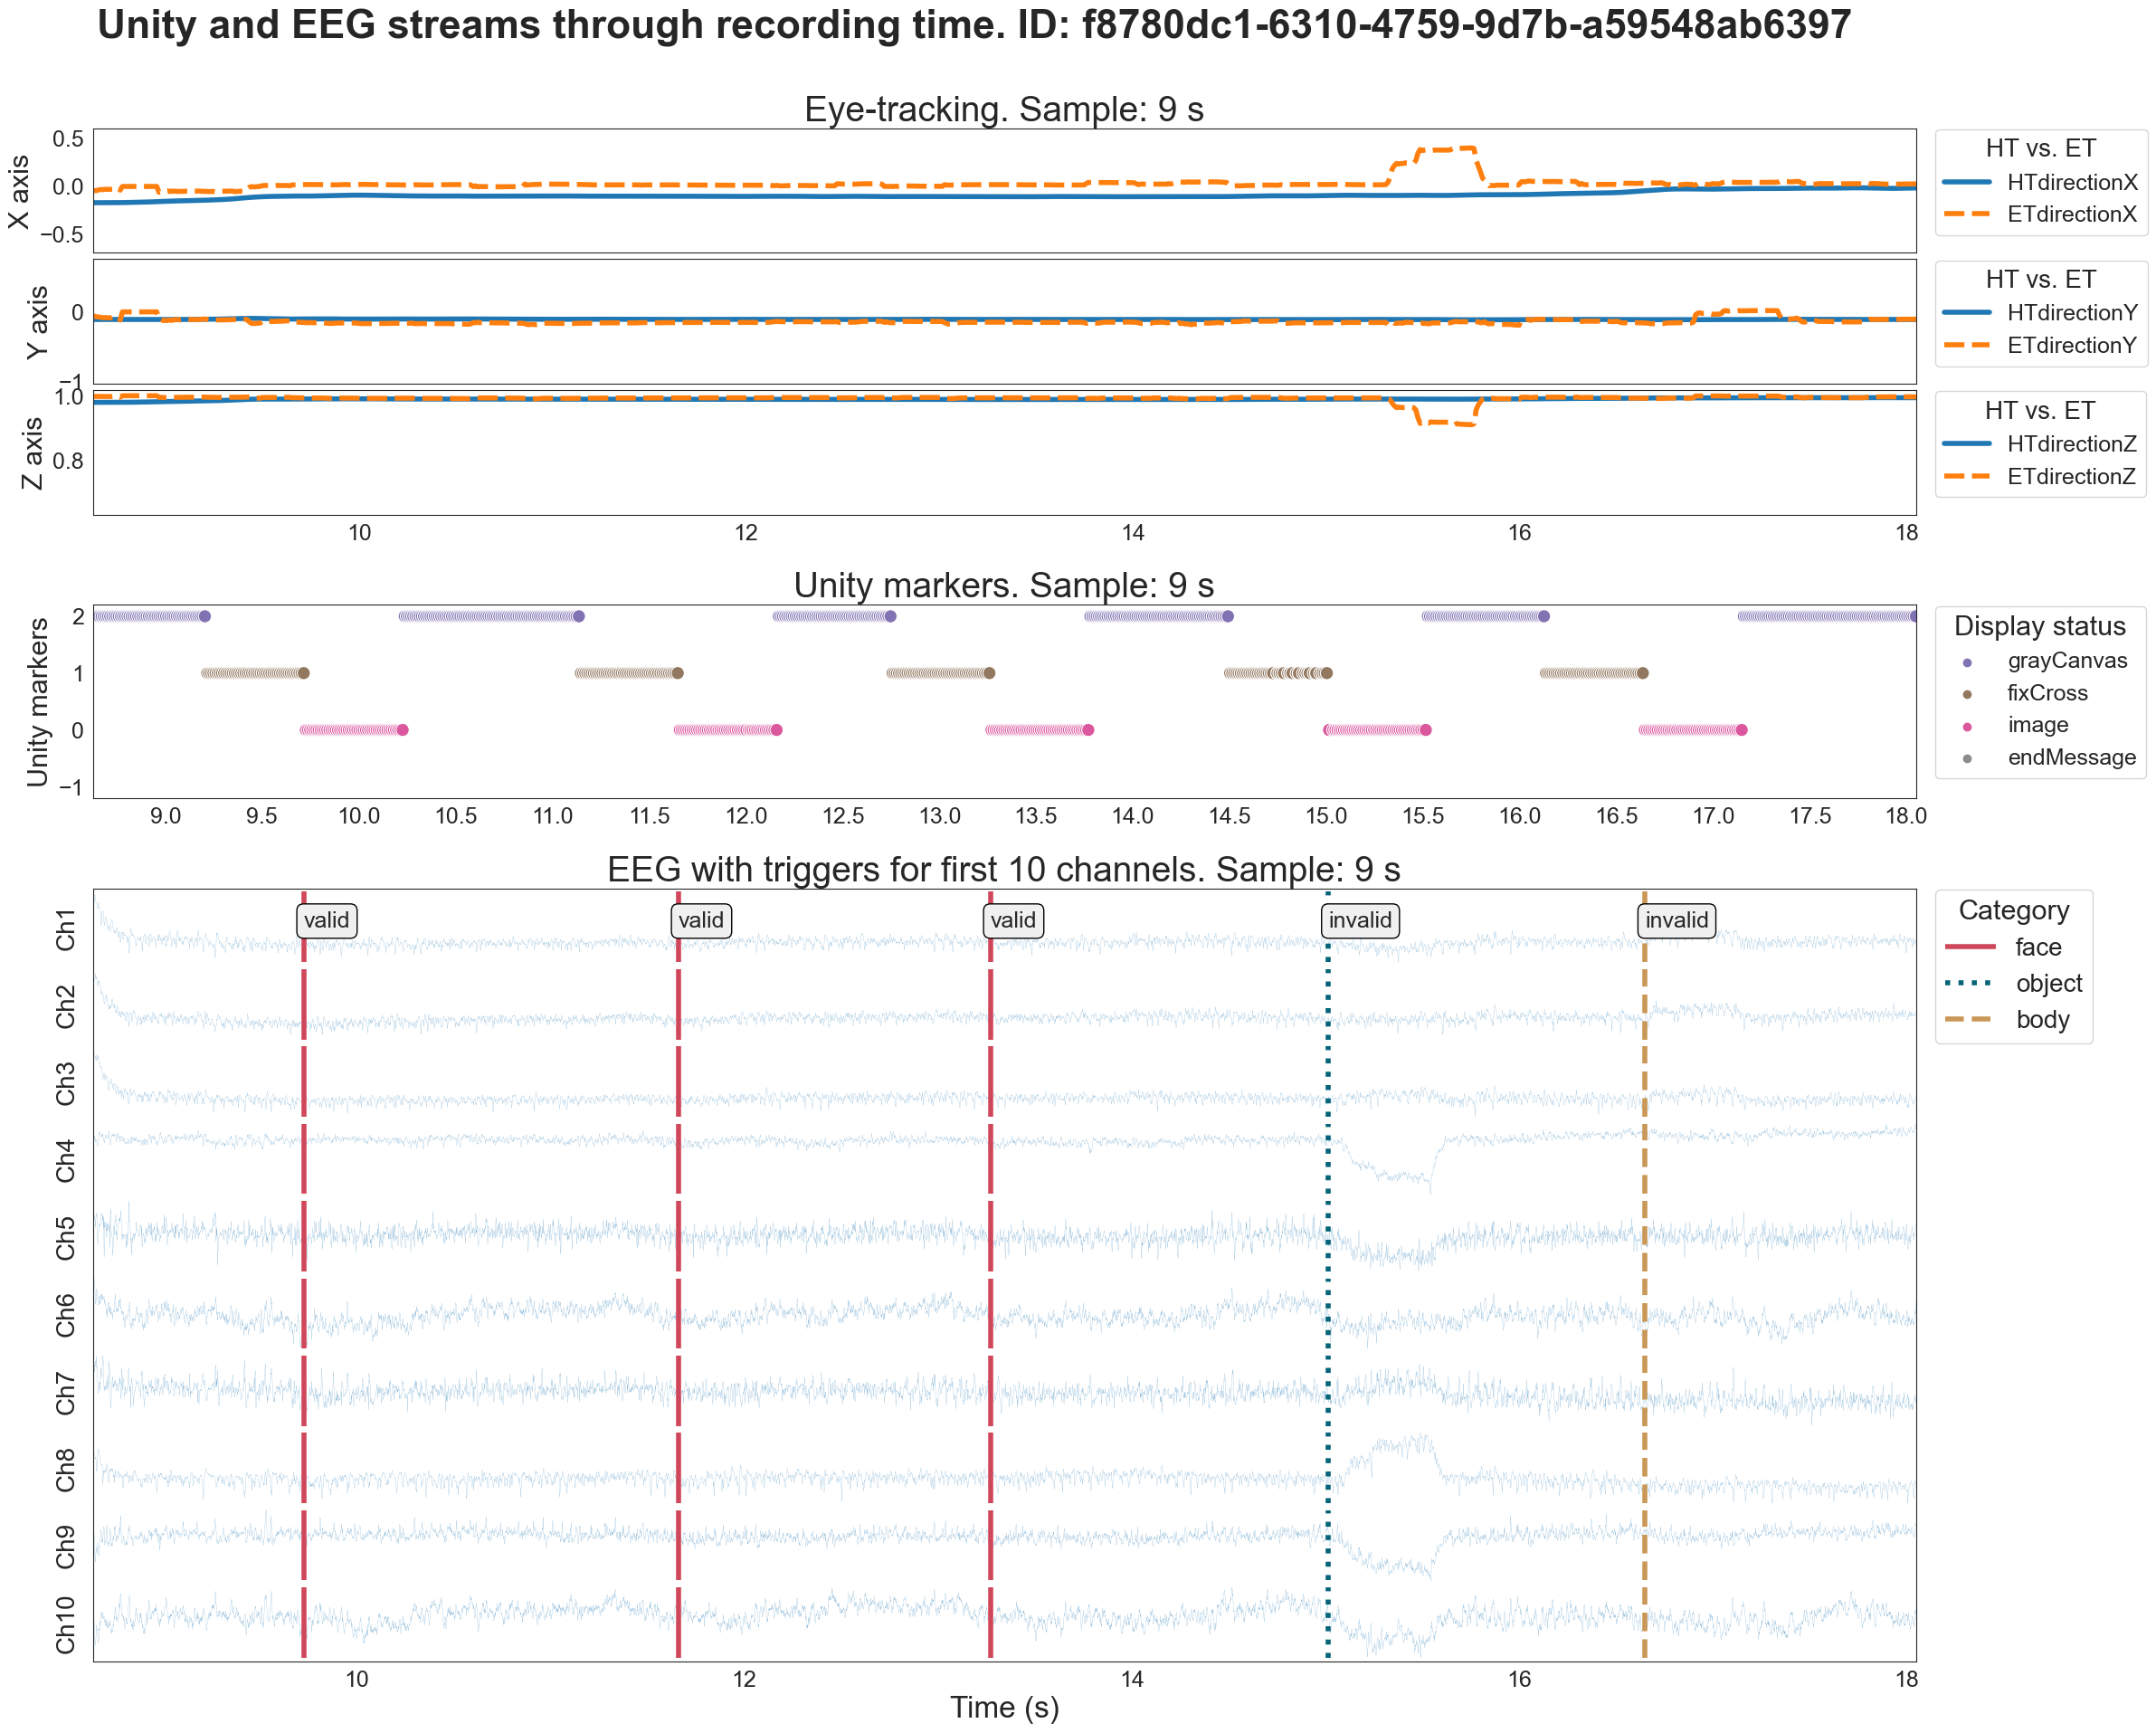

In [50]:
visualize_unity_eeg_all(df, df_eeg_all, id=uid, display_start=0, display_end=16, vis_end=False, shifts_from_end=15, save=False)

In [83]:
import gc
gc.collect()

151798

# 4. General pipeline
Here we extract all streams info for all recordings.
- Extract streams  info
- Create streams, eye, and eeg graphics for every recording
- Create trigger files per recording
- Save data in respective folders as .csv and .pdf

In [124]:
import gc
gc.collect()

# sort data files alphabetically
files_s = os.listdir(r_path)
files_s.sort()
# path to save .csv with total images per block
total_img_file = os.path.join(t_path, 'total_unique_images_per_user.csv')
desc_file_streams = os.path.join(t_path, 'desc_files_streams.csv')

# progress bar format definitons
m_format = "{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt} in {elapsed_s:.2f}s"
s_format = ("{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt}{postfix} in {elapsed_s:.2f}s")
# main progress bar
main_bar = tqdm(
    files_s,
    #os.listdir(r_path),
    desc="Processed",
    dynamic_ncols=True,
    mininterval=0.001,
    bar_format=m_format,
)
# for k in main_bar:
for file in main_bar:
    if file.lower().endswith('.xdf'):
        # Skip if not a first part of a recording
        if 'room2' in file:
            continue
        pbar = tqdm(
        range(7),
        mininterval=0.001,
        maxinterval=1,
        bar_format=s_format,)

        pbar.set_postfix(file=file)
        #### 1. Load the XDF file ####
        postfix = {"step": "1. Load the XDF file", "file": file}
        # set flag if a second recording for same subject
        file2 = file.replace('room1', 'room2')
        second_rec = True if os.path.isfile(os.path.join(r_path, file2)) else False

        pbar.set_postfix(postfix)
        streams, _ = pyxdf.load_xdf(os.path.join(r_path, file))
        # read streams from second file if it exists
        if second_rec:
            streams2, _ = pyxdf.load_xdf(os.path.join(r_path, file2))

        pbar.update(1)
        #### 2. Store selected stream info (only useful info)
        postfix = {"step": "2. Store selected streams info", "file": file}
        pbar.set_postfix(postfix)
        # IMG_INFO: store trigger-related stream data into df and use the EEG stream for first timestamp reference
        df_img_inf = get_streams_data(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal', use_startdiff_correction=True,use_manual_drift=False)
        if second_rec:
            # store the df for second recording if subject has to recordings
            df_img_inf2 = get_streams_data(streams2, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal', use_startdiff_correction=True,use_manual_drift=False)
            # combine both df into one
            df_img_inf = pd.concat([df_img_inf,df_img_inf2], ignore_index=True)

        # drop nan values
        df_img_inf = df_img_inf.dropna().reset_index(drop=True)
        df_img_info_renamed = rename_displays(df_img_inf)

        # EYE_DATA: save eye_tracking related data
        df_eye = get_streams_data(streams, streams_keep=['HitObjectNames', 'HitPositionOnObjects','HeadTracking','EyeTrackingWorld','EyeTrackingLocal'], time_ref_stream='openvibeSignal', use_startdiff_correction=True,use_manual_drift=False)
        if second_rec:
            # save eye df for second recording if subject has to recordings
            df_eye2 = get_streams_data(streams2, streams_keep=['HitObjectNames', 'HitPositionOnObjects','HeadTracking','EyeTrackingWorld','EyeTrackingLocal'], time_ref_stream='openvibeSignal', use_startdiff_correction=True,use_manual_drift=False)
            # combine both df into one
            df_eye = pd.concat([df_eye,df_eye2], ignore_index=True)
        pbar.update(1)

        ### 2.1 merge Unity imageInfo and Eye dataframes
        # We want to have only one df with Unity img_info and eye tracking data
        merged_img_eye_df = merge_img_eye_streams_data(df_img_info_renamed, df_eye)

        #### 3. Create triggers ####
        postfix = {"step": "3. Creating triggers from ImageInfo", "file": file}
        pbar.set_postfix(postfix)
        df_merged, df_triggers, uid = create_triggers(merged_img_eye_df)  # df, df_triggers, uid = create_triggers(merged_img_eye_df)
        pbar.update(1)

        #### 4. Create and save visualizations ####
        postfix = {"step": "4.  Creating and saving visualizations", "file": file}
        pbar.set_postfix(postfix)
        # get some seconds of the eeg data from streams, not all
        _, df_eeg_all = stract_eeg_data(streams)
        # take the first 30 seconds of recording (30s x 90fps) and rename names in 'displayStatusNames' column
        ###### df_renamed = rename_displays(df)

        # visualize the first 30 seconds of recording
        visualize_unity_eeg_all(df_merged, df_eeg_all, time_fragment='start', id=uid, display_start=0, display_end=16, vis_end=False, save=True)
        plt.close()
        # visualize 5 shifts (display statuses) from shift 100 to 105
        visualize_unity_eeg_all(df_merged, df_eeg_all, time_fragment='', id=uid, display_start=100, display_end=105, vis_end=False, save=True)
        plt.close()
        visualize_unity_eeg_all(df_merged, df_eeg_all, time_fragment='end', id=uid, vis_end=True, shifts_from_end=15, save=True)
        plt.close()
        pbar.update(1)

        #### 5. Save total number of images per block, per uid  ####
        postfix = {"step": "5 Saving total number of images per block, per uid", "file": file}
        pbar.set_postfix(postfix)
        # convert column to numeric to drop the duplicates correctly
        #total_images['block_number'] = pd.to_numeric(total_images['block_number'])
        total_images = valid_images(df_merged)

        # save total images for all participants
        if not os.path.isdir(t_path):
            os.mkdir(t_path)
        if not os.path.isdir(e_path):
            os.mkdir(e_path)
        desc_streams = describe_recordings(streams, file_name=file)

        #### 6. Create streams description per recording  ####
        postfix = {"step": "6. Creating triggers from ImageInfo", "file": file}
        pbar.set_postfix(postfix)
        if os.path.exists(desc_file_streams):
            df_desc_files = pd.read_csv(desc_file_streams)
            df_desc_files = pd.concat([df_desc_files,desc_streams], ignore_index=True)
            df_desc_files.reset_index(drop=True, inplace=True)
            df_desc_files.drop_duplicates(inplace=True, ignore_index=True)
        else:
            df_desc_files = desc_streams
        df_desc_files.to_csv(desc_file_streams, index=False)
        pbar.update(1)

        total_images['uid'] = uid # add colum to total images csv with uid
        if os.path.exists(total_img_file):
            df_total_unique_img = pd.read_csv(total_img_file)
            df_total_unique_img = pd.concat([df_total_unique_img,total_images], ignore_index=True)
            df_total_unique_img.reset_index(drop=True, inplace=True)
            df_total_unique_img.drop_duplicates(inplace=True, ignore_index=True)

        else:
            df_total_unique_img = total_images
        df_total_unique_img.to_csv(total_img_file, index=False)
        pbar.update(1)
        #### 7. Saving triggers, ET, and full_streams_csv files ####
        postfix = {"step": "7. Saving triggers and et files", "file": file}
        pbar.set_postfix(postfix)
        df_triggers.to_csv(os.path.join(t_path, 'trigger_file_' + uid +'.csv'), index=False)
        df_eye.to_csv(os.path.join(e_path, 'et_' + uid + '.csv'), index=False)
        merged_img_eye_df.to_csv(os.path.join(all_csv_path, 'all_streams_' + uid + '.csv'), index=False) # make sure the folder exists
        pbar.update(1)
        pbar.set_postfix(file=file)
        pbar.close()

Processed:            0% 0/31 in 0.02s

:            0% 0/7 in 0.02s


Participant UID: ed990ae1-f2e6-4e25-b6c1-e596181c248a
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 934259.7003590572 and end time is 937974.1056302808
Unity start time is 934259.9698537304 and end time is 937961.1040700441
 !! Unity delayed recording start by 0.26949467323720455 seconds detected
 -- Unity ImageInfo start time is 934259.9698579088 and end time is 937961.1040700441
 -- Unity Visual start time is 934259.9698537304 and end time is 937961.104063568
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 0.0 (milliseconds)
 !! Making corrections using a normalized drift in ms per one minute of duration at -1.25256887748983
Ending drift between Unity and openvibeSignal is -13001.560236676596 (milliseconds)
Additional drift over time is -13001.56 (milliseconds)
Shift channel 'ImageInfo' by

:            0% 0/7 in 0.04s


Participant UID: dfb99d79-4595-4a0d-b346-23282e000f10
Streams to keep: ['Visual', 'ImageInfo'] and reference stream ['openvibeSignal']
openvibeSignal start time is 1021241.6728103163 and end time is 1025199.078084025
Unity start time is 1021257.6298472201 and end time is 1025199.1210294464
 !! Unity delayed recording start by 15.95703690382652 seconds detected
 -- Unity Visual start time is 1021257.6298472201 and end time is 1025199.1210198735
 -- Unity ImageInfo start time is 1021257.6298598284 and end time is 1025199.1210294464
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 0.0 (milliseconds)
 !! Making corrections using a normalized drift in ms per one minute of duration at -1.25256887748983
Ending drift between Unity and openvibeSignal is 42.94542141724378 (milliseconds)
Additional drift over time is 42.95 (milliseconds)
Shift channel 'ImageInfo' by

:            0% 0/7 in 0.02s


Participant UID: f8780dc1-6310-4759-9d7b-a59548ab6397
Streams to keep: ['Visual', 'ImageInfo'] and reference stream ['openvibeSignal']
openvibeSignal start time is 532357.7540644857 and end time is 536241.6905890936
Unity start time is 532358.001049673 and end time is 536239.3086369165
 !! Unity delayed recording start by 0.2469851872883737 seconds detected
 -- Unity Visual start time is 532358.001049673 and end time is 536239.3086351864
 -- Unity ImageInfo start time is 532358.0010562824 and end time is 536239.3086369165
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 0.0 (milliseconds)
 !! Making corrections using a normalized drift in ms per one minute of duration at -1.25256887748983
Ending drift between Unity and openvibeSignal is -2381.9521771511063 (milliseconds)
Additional drift over time is -2381.95 (milliseconds)
Shift channel 'ImageInfo' by -1

:            0% 0/7 in 0.02s


Participant UID: cce2217f-677a-4b91-9a3b-3cee0abc396c
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 352805.7947427269 and end time is 356975.70001679234
Unity start time is 352826.52692855225 and end time is 356976.0252530591
 !! Unity delayed recording start by 20.494001118059266 seconds detected
 -- Unity ImageInfo start time is 352826.52693857567 and end time is 356976.0252530591
 -- Unity Visual start time is 352826.52692855225 and end time is 356976.025245616
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 238.18470729701653 (milliseconds)
 !! Making corrections using a normalized drift in ms per one minute of duration at -1.25256887748983
Ending drift between Unity and openvibeSignal is 325.23626676993445 (milliseconds)
Additional drift over time is 87.05 (milliseconds)
Shift channel '

:            0% 0/7 in 0.10s


Participant UID: 6a23f1a0-bdeb-4afd-af1c-cd7e607a93e0
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 63324.21422768189 and end time is 67502.11950289809
Unity start time is 63367.3154229652 and end time is 67502.30997303064
 !! Unity delayed recording start by 42.99794371943272 seconds detected
 -- Unity ImageInfo start time is 63367.31543165954 and end time is 67502.30997303064
 -- Unity Visual start time is 63367.3154229652 and end time is 67502.30996776995
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 103.25156387415838 (milliseconds)
 !! Making corrections using a normalized drift in ms per one minute of duration at -1.25256887748983
Ending drift between Unity and openvibeSignal is 190.47013255476486 (milliseconds)
Additional drift over time is 87.22 (milliseconds)
Shift channel 'ImageI

:            0% 0/7 in 0.04s


Participant UID: a9412d68-6eaf-4a1f-ab61-b2f408ac5b47
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 64420.25626493343 and end time is 68488.6615390774
Unity start time is 64420.435319307944 and end time is 68488.94141095469
 -- Unity ImageInfo start time is 64420.43533355376 and end time is 68488.93030628045
 -- Unity Visual start time is 64420.435319307944 and end time is 68488.94141095469
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 11.1 (milliseconds)
Starting drift between Unity and openvibeSignal is 179.05437451554462 (milliseconds)
Ending drift between Unity and openvibeSignal is 279.8718772974098 (milliseconds)
Additional drift over time is 100.82 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 3182
Missing chunk 2 length 3129
Missing chunk 3 length 2969
Size of ori

:            0% 0/7 in 0.06s


Participant UID: 68f235ce-7948-4d1d-b50f-85dbbbf4c506
Streams to keep: ['Visual', 'ImageInfo'] and reference stream ['openvibeSignal']
openvibeSignal start time is 507766.743312486 and end time is 509956.7110842106
Unity start time is 507767.02085224586 and end time is 509957.01946864906
 -- Unity Visual start time is 507767.02085224586 and end time is 509957.0194662563
 -- Unity ImageInfo start time is 507767.0208561681 and end time is 509957.01946864906
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 277.5397598743439 (milliseconds)
Ending drift between Unity and openvibeSignal is 308.3844384527765 (milliseconds)
Additional drift over time is 30.84 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 2950
Size of original timestamps (194157,)
Size of ts_complete (197107,)


:            0% 0/7 in 0.01s


Participant UID: 41862e7e-bb0d-484c-9149-37175debeff7
Streams to keep: ['Visual', 'ImageInfo'] and reference stream ['openvibeSignal']
openvibeSignal start time is 6158.856278501852 and end time is 11078.26155377695
Unity start time is 6159.1505142254055 and end time is 11078.643156843167
 -- Unity Visual start time is 6159.1505142254055 and end time is 11078.643146733973
 -- Unity ImageInfo start time is 6159.150528653556 and end time is 11078.643156843167
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 294.23572355335637 (milliseconds)
Ending drift between Unity and openvibeSignal is 381.6030662164849 (milliseconds)
Additional drift over time is 87.37 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 2962
Missing chunk 2 length 2948
Missing chunk 3 length 2953
Missing c

:            0% 0/7 in 0.03s


Participant UID: 87c8f5f3-9dc8-481b-821e-7fc676da19f5
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 74450.99131073887 and end time is 78908.89658320707
Unity start time is 74451.18333386455 and end time is 78909.18864843482
 -- Unity ImageInfo start time is 74451.18333386455 and end time is 78909.18864843482
 -- Unity Visual start time is 74451.19443607575 and end time is 78909.18864376971
 -- All Unity streams start time difference is 11.1 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 192.023125680862 (milliseconds)
Ending drift between Unity and openvibeSignal is 292.06522775348276 (milliseconds)
Additional drift over time is 100.04 (milliseconds)
Shift channel 'ImageInfo' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 4033
Missing chunk 2 length 3080
Missing chunk 3 length 2968
Missing chunk 4 length 2953
Missing chunk 

:            0% 0/7 in 0.03s


Participant UID: 50ad9e5b-fb4c-4e3e-92ea-bf422d43d4d6
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 157308.45428194292 and end time is 162049.35955358765
Unity start time is 157308.62735261035 and end time is 162049.62735271407
 -- Unity ImageInfo start time is 157308.62736097386 and end time is 162049.62735271407
 -- Unity Visual start time is 157308.62735261035 and end time is 162049.62734736118
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 173.0706674279645 (milliseconds)
Ending drift between Unity and openvibeSignal is 267.79912642086856 (milliseconds)
Additional drift over time is 94.73 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 3516
Missing chunk 2 length 3166
Missing chunk 3 length 3467
Missin

:            0% 0/7 in 0.04s


Participant UID: 0f06d331-98f0-419a-8a39-17be51b6bfff
Streams to keep: ['Visual', 'ImageInfo'] and reference stream ['openvibeSignal']
openvibeSignal start time is 166026.12838055487 and end time is 171740.5024057541
Unity start time is 166026.3163403308 and end time is 171740.81559200044
 -- Unity Visual start time is 166026.3163403308 and end time is 171740.81558173907
 -- Unity ImageInfo start time is 166026.31635091608 and end time is 171740.81559200044
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 187.9597759398166 (milliseconds)
Ending drift between Unity and openvibeSignal is 313.1862463487778 (milliseconds)
Additional drift over time is 125.23 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 2993
Missing chunk 2 length 3069
Missing chunk 3 length 3138
Missing c

:            0% 0/7 in 0.04s


Participant UID: 7d4ab496-f88c-4965-9a8f-4aaa9ae50f13
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 1248700.9365493814 and end time is 1252878.8418192228
Unity start time is 1248701.1966685234 and end time is 1252879.1957813755
 -- Unity ImageInfo start time is 1248701.1966774152 and end time is 1252879.1957813755
 -- Unity Visual start time is 1248701.1966685234 and end time is 1252879.1957737824
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 260.119142010808 (milliseconds)
Ending drift between Unity and openvibeSignal is 353.96215273067355 (milliseconds)
Additional drift over time is 93.84 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 2964
Missing chunk 2 length 3093
Missing chunk 3 length 3001
Missing

:            0% 0/7 in 0.02s


Participant UID: 9e3d1bd2-e8c6-4ae0-ad31-fe1a6199c62b
Streams to keep: ['Visual', 'ImageInfo'] and reference stream ['openvibeSignal']
openvibeSignal start time is 1421899.275003015 and end time is 1426219.1802690707
Unity start time is 1421899.4950629603 and end time is 1426219.4876249302
 -- Unity Visual start time is 1421899.495063705 and end time is 1426219.4876123914
 -- Unity ImageInfo start time is 1421899.4950629603 and end time is 1426219.4876249302
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 220.05994524806738 (milliseconds)
Ending drift between Unity and openvibeSignal is 307.3558595497161 (milliseconds)
Additional drift over time is 87.3 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 3025
Missing chunk 2 length 3358
Missing chunk 3 length 3159
Missing c

:            0% 0/7 in 0.01s


Participant UID: 7afcd75b-9094-4fdf-9e33-70a99439deda
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 1543711.135372116 and end time is 1547736.5406443174
Unity start time is 1543711.3629807755 and end time is 1547736.861862908
 -- Unity ImageInfo start time is 1543711.3629874496 and end time is 1547736.861862908
 -- Unity Visual start time is 1543711.3629807755 and end time is 1547736.861859817
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 227.60865953750908 (milliseconds)
Ending drift between Unity and openvibeSignal is 321.21859048493207 (milliseconds)
Additional drift over time is 93.61 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 3251
Missing chunk 2 length 3077
Missing chunk 3 length 2996
Missing c

:            0% 0/7 in 0.02s


Participant UID: 944be082-2674-42b2-9f50-7849d9e14946
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 1446671.6458478465 and end time is 1450636.0511226286
Unity start time is 1446671.818996357 and end time is 1450635.3468653439
 !! Unity delayed recording start by 0.17314851051196456 seconds detected
 -- Unity ImageInfo start time is 1446671.8190033957 and end time is 1450635.3468653439
 -- Unity Visual start time is 1446671.818996357 and end time is 1450635.3468563033
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 0.0 (milliseconds)
 !! Making corrections using a normalized drift in ms per one minute of duration at -1.25256887748983
Ending drift between Unity and openvibeSignal is -704.2572847567499 (milliseconds)
Additional drift over time is -704.26 (milliseconds)
Shift channel 'ImageInfo

:            0% 0/7 in 0.02s


Participant UID: 9771ad44-64a5-476d-90e9-d591ad1f6e2c
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 16730.041945600457 and end time is 21628.447219417074
Unity start time is 16730.346443065042 and end time is 21628.850000766568
 -- Unity ImageInfo start time is 16730.346451955436 and end time is 21628.850000766568
 -- Unity Visual start time is 16730.346443065042 and end time is 21628.849992779767
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 304.49746458543814 (milliseconds)
Ending drift between Unity and openvibeSignal is 402.78134949403466 (milliseconds)
Additional drift over time is 98.28 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 3177
Missing chunk 2 length 2989
Missing chunk 3 length 2999
Missi

:            0% 0/7 in 0.05s


Participant UID: 02c5e2dc-2cd8-4d48-9d4e-16d55a8fe6d2
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 5948.056016432805 and end time is 9996.961290741036
Unity start time is 5948.264367707584 and end time is 9997.269811899452
 -- Unity ImageInfo start time is 5948.264377063488 and end time is 9997.269811899452
 -- Unity Visual start time is 5948.264367707584 and end time is 9997.269803877329
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 208.35127477857895 (milliseconds)
Ending drift between Unity and openvibeSignal is 308.52115841662453 (milliseconds)
Additional drift over time is 100.17 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 3312
Missing chunk 2 length 3186
Missing chunk 3 length 2966
Missing chun

:            0% 0/7 in 0.04s


Participant UID: 723c8bc5-7809-4dfc-990c-36de0f544b72
Streams to keep: ['ImageInfo', 'Visual'] and reference stream ['openvibeSignal']
openvibeSignal start time is 276394.8256276842 and end time is 280395.2309020102
Unity start time is 276395.08897978597 and end time is 280395.5944279137
 -- Unity ImageInfo start time is 276395.0889902602 and end time is 280395.5944279137
 -- Unity Visual start time is 276395.08897978597 and end time is 280395.5834126013
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 11.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 263.3521017851308 (milliseconds)
Ending drift between Unity and openvibeSignal is 363.5259034927003 (milliseconds)
Additional drift over time is 100.17 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 2954
Missing chunk 2 length 2971
Missing chunk 3 length 2953
Missing chu

:            0% 0/7 in 0.03s


Participant UID: c304049a-99c5-4184-abd1-ba2178c5e1e6
Streams to keep: ['Visual', 'ImageInfo'] and reference stream ['openvibeSignal']
openvibeSignal start time is 90275.54623195817 and end time is 94508.9515060954
Unity start time is 90275.76089333574 and end time is 94505.8962332574
 !! Unity delayed recording start by 0.2146613775694277 seconds detected
 -- Unity Visual start time is 90275.76089333574 and end time is 94505.89622448993
 -- Unity ImageInfo start time is 90275.76090620455 and end time is 94505.8962332574
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 0.0 (milliseconds)
 !! Making corrections using a normalized drift in ms per one minute of duration at -1.25256887748983
Ending drift between Unity and openvibeSignal is -3055.2728379989276 (milliseconds)
Additional drift over time is -3055.27 (milliseconds)
Shift channel 'ImageInfo' by -1


:            0% 0/7 in 0.09s


Participant UID: 7d9620d5-bbd8-4c63-ab0b-72a3e0a0137a
Streams to keep: ['Visual', 'ImageInfo'] and reference stream ['openvibeSignal']
openvibeSignal start time is 350100.7035909634 and end time is 354054.1088625772
Unity start time is 350100.9933710091 and end time is 354054.49741570343
 -- Unity Visual start time is 350100.9933710091 and end time is 354054.497412733
 -- Unity ImageInfo start time is 350100.99337509886 and end time is 354054.49741570343
 -- All Unity streams start time difference is 0.0 (milliseconds)
 -- All Unity streams end time difference is 0.0 (milliseconds)
Starting drift between Unity and openvibeSignal is 289.78004574310035 (milliseconds)
Ending drift between Unity and openvibeSignal is 388.55312624946237 (milliseconds)
Additional drift over time is 98.77 (milliseconds)
Shift channel 'ImageInfo' by -1
Shift channel 'Visual' by -1

Dedrifting channel 'ImageInfo'...
Missing chunk 1 length 2954
Missing chunk 2 length 2958
Missing chunk 3 length 2939
Missing chu